<a href="https://colab.research.google.com/github/matheuslemesam/Bird_Detection-DL/blob/main/Bird_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bird Detection, projeto de detecção de espécies de pássaros utilizando Redes Convolucionais. UnB/FCTE - 2025.2 - Professor Vinicius Rispoli**

**Para começar o projeto, definimos possíveis arquiteturas mais promissoras: entre elas YOLO, U-Net, EfficientNetV2-L, EfficientNet-B4, ConvNeXt-Tiny. A EfficientNetV2-L foi a que mais se destacou pelo fato de ter uma precisão melhor, treinamento mais robusto e uma melhor tecnologia de detecção.**

## **Importação do Dataset do Google Drive: montar o Google Drive para acessar o dataset de pássaros.**

Começamos iniciando a GPU e vendo se foi iniciada.

In [ ]:
!nvidia-smi

Wed Oct 15 02:50:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
import os
from pathlib import Path
import shutil

# Montar o Google Drive
# Verifica se o diretório de montagem não está vazio e o limpa se necessário
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
    print("Limpeza do diretório de montagem '/content/drive'...")
    for item in os.listdir('/content/drive'):
        item_path = os.path.join('/content/drive', item)
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)
    print("Diretório de montagem limpo.")

drive.mount('/content/drive')

# Definir caminhos para Google Colab
base_path = '/content/drive/MyDrive/Dataset_Aves'
dataset_path = os.path.join(base_path, 'original')
output_path = os.path.join(base_path, 'augmentation')

# Verificar se o dataset existe
if os.path.exists(dataset_path):
    print(f"Dataset encontrado em: {dataset_path}")

    # Listar as espécies disponíveis
    species = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Espécies encontradas ({len(species)}): {species}")

    # Contar imagens por espécie
    total_images = 0
    for specie in species:
        specie_path = os.path.join(dataset_path, specie)
        img_count = len([f for f in os.listdir(specie_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   {specie}: {img_count} imagens")
        total_images += img_count

    print(f"\nTotal de imagens no dataset: {total_images}")
    print(f"Pasta de entrada: {dataset_path}")
    print(f"Pasta de saída: {output_path}")

else:
    print(f"Dataset não encontrado em: {dataset_path}")
    print("Verifique o caminho do dataset")

Limpeza do diretório de montagem '/content/drive'...
Diretório de montagem limpo.
Mounted at /content/drive
Dataset encontrado em: /content/drive/MyDrive/Dataset_Aves/original
Espécies encontradas (14): ['amazona_amazonica', 'ara_macao', 'amazona_aestiva', 'forpus_xanthopterygius', 'primolius_maracana', 'anodorhynchus_hyacinthinus', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'psittacara_leucophthalmus', 'ara_ararauna', 'touit_melanonotus', 'ara_chloropterus', 'orthopsittaca_manilatus', 'eupsittula_aurea']
   amazona_amazonica: 189 imagens
   ara_macao: 172 imagens
   amazona_aestiva: 240 imagens
   forpus_xanthopterygius: 215 imagens
   primolius_maracana: 195 imagens
   anodorhynchus_hyacinthinus: 250 imagens
   brotogeris_chiriri: 186 imagens
   diopsittaca_nobilis: 217 imagens
   psittacara_leucophthalmus: 222 imagens
   ara_ararauna: 240 imagens
   touit_melanonotus: 150 imagens
   ara_chloropterus: 203 imagens
   orthopsittaca_manilatus: 184 imagens
   eupsittula_aurea: 216 imag

## **Data Augmentation: aumentar os dados de forma artificial, neste caso com rotações, translações e espelhamento.**

Para o data augmentation, primeiramente importamos as bibliotecas necessárias, Pytorch e Keras.

In [ ]:
!pip install -U torch torchvision torchaudio
!pip install -U keras scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


Aqui é feito a parte de transformações de imagem: translação, rotação e espelhamento, não é feito aplicação de filtros já que as cores são características de distinção em aves. Também é feito o upload do dataset augmentado no google drive, uma boa prática para não precisar ficar rodando o código toda vez que for utilizar e para guardar o dataset augmentado.

In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm # melhor visualização na barra de progresso


source_dir = dataset_path # Onde estão as imagens originais
target_dir = output_path # Onde as novas imagens serão salvas
target_images_per_class = 1000

# Nota: NÃO usamos ToTensor() ou Normalize() aqui, pois queremos salvar
# as imagens como arquivos .jpg/.png, não como tensores.
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.7, 1.0)), # Corta e redimensiona de forma mais agressiva
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30), # Aumenta a rotação
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10), # Pequenas distorções
])

print(f"Iniciando o processo de aumento de dados.")
print(f"Diretório de origem: {source_dir}")
print(f"Diretório de destino: {target_dir}\n")

# Garante que o diretório de destino principal exista
os.makedirs(target_dir, exist_ok=True)

# Lista todas os subdiretórios
class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for class_name in class_names:
    source_class_path = os.path.join(source_dir, class_name)
    target_class_path = os.path.join(target_dir, class_name)

    # Cria o subdiretório de destino para a classe
    os.makedirs(target_class_path, exist_ok=True)

    # Lista todas as imagens originais
    original_images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(original_images)

    print(f"Processando classe: '{class_name}'")
    print(f"  Encontradas {num_original} imagens originais.")

    # Copia as imagens originais
    print(f"  Copiando originais para o destino...")
    for img_name in tqdm(original_images, desc=f"Copiando {class_name}"):
        source_img_path = os.path.join(source_class_path, img_name)
        target_img_path = os.path.join(target_class_path, img_name)
        img = Image.open(source_img_path).convert("RGB")
        img.save(target_img_path)

    # Gera novas imagens
    num_to_generate = target_images_per_class - num_original
    if num_to_generate <= 0:
        print(f"  A classe '{class_name}' já possui {num_original} imagens. Nenhuma imagem nova será gerada.\n")
        continue

    print(f"  Gerando {num_to_generate} novas imagens via augmentation...")
    for i in tqdm(range(num_to_generate), desc=f"Gerando {class_name}"):
        # Escolhe uma imagem original aleatória como base
        random_image_name = random.choice(original_images)
        base_image_path = os.path.join(source_class_path, random_image_name)

        # Abre a imagem com a biblioteca PIL
        with Image.open(base_image_path).convert("RGB") as img:
            # Aplica a transformação de augmentation
            augmented_img = augmentation_transform(img)

            # Salva a nova imagem com um nome único
            new_image_name = f"aug_{i+1}_{random_image_name}"
            save_path = os.path.join(target_class_path, new_image_name)
            augmented_img.save(save_path)
    print(f"  Classe '{class_name}' finalizada.\n")

print("="*50)
print("PROCESSO DE DATA AUGMENTATION CONCLUÍDO!")
print(f"O novo dataset está pronto em: {target_dir}")
print("="*50)

Iniciando o processo de aumento de dados.
Diretório de origem: /content/drive/MyDrive/Dataset_Aves/original
Diretório de destino: /content/drive/MyDrive/Dataset_Aves/augmentation

Processando classe: 'amazona_amazonica'
  Encontradas 189 imagens originais.
  Copiando originais para o destino...


Copiando amazona_amazonica:   0%|          | 0/189 [00:00<?, ?it/s]

  Gerando 811 novas imagens via augmentation...


Gerando amazona_amazonica:   0%|          | 0/811 [00:00<?, ?it/s]

  Classe 'amazona_amazonica' finalizada.

Processando classe: 'ara_macao'
  Encontradas 172 imagens originais.
  Copiando originais para o destino...


Copiando ara_macao:   0%|          | 0/172 [00:00<?, ?it/s]

  Gerando 828 novas imagens via augmentation...


Gerando ara_macao:   0%|          | 0/828 [00:00<?, ?it/s]

  Classe 'ara_macao' finalizada.

Processando classe: 'amazona_aestiva'
  Encontradas 240 imagens originais.
  Copiando originais para o destino...


Copiando amazona_aestiva:   0%|          | 0/240 [00:00<?, ?it/s]

  Gerando 760 novas imagens via augmentation...


Gerando amazona_aestiva:   0%|          | 0/760 [00:00<?, ?it/s]

  Classe 'amazona_aestiva' finalizada.

Processando classe: 'forpus_xanthopterygius'
  Encontradas 215 imagens originais.
  Copiando originais para o destino...


Copiando forpus_xanthopterygius:   0%|          | 0/215 [00:00<?, ?it/s]

  Gerando 785 novas imagens via augmentation...


Gerando forpus_xanthopterygius:   0%|          | 0/785 [00:00<?, ?it/s]

  Classe 'forpus_xanthopterygius' finalizada.

Processando classe: 'primolius_maracana'
  Encontradas 195 imagens originais.
  Copiando originais para o destino...


Copiando primolius_maracana:   0%|          | 0/195 [00:00<?, ?it/s]

  Gerando 805 novas imagens via augmentation...


Gerando primolius_maracana:   0%|          | 0/805 [00:00<?, ?it/s]

  Classe 'primolius_maracana' finalizada.

Processando classe: 'anodorhynchus_hyacinthinus'
  Encontradas 250 imagens originais.
  Copiando originais para o destino...


Copiando anodorhynchus_hyacinthinus:   0%|          | 0/250 [00:00<?, ?it/s]

  Gerando 750 novas imagens via augmentation...


Gerando anodorhynchus_hyacinthinus:   0%|          | 0/750 [00:00<?, ?it/s]

  Classe 'anodorhynchus_hyacinthinus' finalizada.

Processando classe: 'brotogeris_chiriri'
  Encontradas 186 imagens originais.
  Copiando originais para o destino...


Copiando brotogeris_chiriri:   0%|          | 0/186 [00:00<?, ?it/s]

  Gerando 814 novas imagens via augmentation...


Gerando brotogeris_chiriri:   0%|          | 0/814 [00:00<?, ?it/s]

  Classe 'brotogeris_chiriri' finalizada.

Processando classe: 'diopsittaca_nobilis'
  Encontradas 217 imagens originais.
  Copiando originais para o destino...


Copiando diopsittaca_nobilis:   0%|          | 0/217 [00:00<?, ?it/s]

  Gerando 783 novas imagens via augmentation...


Gerando diopsittaca_nobilis:   0%|          | 0/783 [00:00<?, ?it/s]

  Classe 'diopsittaca_nobilis' finalizada.

Processando classe: 'psittacara_leucophthalmus'
  Encontradas 222 imagens originais.
  Copiando originais para o destino...


Copiando psittacara_leucophthalmus:   0%|          | 0/222 [00:00<?, ?it/s]

  Gerando 778 novas imagens via augmentation...


Gerando psittacara_leucophthalmus:   0%|          | 0/778 [00:00<?, ?it/s]

  Classe 'psittacara_leucophthalmus' finalizada.

Processando classe: 'ara_ararauna'
  Encontradas 240 imagens originais.
  Copiando originais para o destino...


Copiando ara_ararauna:   0%|          | 0/240 [00:00<?, ?it/s]

  Gerando 760 novas imagens via augmentation...


Gerando ara_ararauna:   0%|          | 0/760 [00:00<?, ?it/s]

  Classe 'ara_ararauna' finalizada.

Processando classe: 'touit_melanonotus'
  Encontradas 150 imagens originais.
  Copiando originais para o destino...


Copiando touit_melanonotus:   0%|          | 0/150 [00:00<?, ?it/s]

  Gerando 850 novas imagens via augmentation...


Gerando touit_melanonotus:   0%|          | 0/850 [00:00<?, ?it/s]

  Classe 'touit_melanonotus' finalizada.

Processando classe: 'ara_chloropterus'
  Encontradas 203 imagens originais.
  Copiando originais para o destino...


Copiando ara_chloropterus:   0%|          | 0/203 [00:00<?, ?it/s]

  Gerando 797 novas imagens via augmentation...


Gerando ara_chloropterus:   0%|          | 0/797 [00:00<?, ?it/s]

  Classe 'ara_chloropterus' finalizada.

Processando classe: 'orthopsittaca_manilatus'
  Encontradas 184 imagens originais.
  Copiando originais para o destino...


Copiando orthopsittaca_manilatus:   0%|          | 0/184 [00:00<?, ?it/s]

  Gerando 816 novas imagens via augmentation...


Gerando orthopsittaca_manilatus:   0%|          | 0/816 [00:00<?, ?it/s]

  Classe 'orthopsittaca_manilatus' finalizada.

Processando classe: 'eupsittula_aurea'
  Encontradas 216 imagens originais.
  Copiando originais para o destino...


Copiando eupsittula_aurea:   0%|          | 0/216 [00:00<?, ?it/s]

  Gerando 784 novas imagens via augmentation...


Gerando eupsittula_aurea:   0%|          | 0/784 [00:00<?, ?it/s]

  Classe 'eupsittula_aurea' finalizada.

PROCESSO DE DATA AUGMENTATION CONCLUÍDO!
O novo dataset está pronto em: /content/drive/MyDrive/Dataset_Aves/augmentation


Devido a GPU estar muito para esperando os dados chegarem do google drive, esta célula de código foi feita para salvar os dados localmente e sanar com este problema.

In [ ]:
import os
import time

drive_source_dir = '/content/drive/MyDrive/Dataset_Aves/augmentation'

local_data_dir = '/content/local_dataset'

print("="*50)
print(f"Iniciando a cópia do dataset de '{drive_source_dir}' para '{local_data_dir}'")
print("aguarde...")
print("="*50)

start_time = time.time()

# Usamos rsync para uma cópia rápida e com barra de progresso
# O comando ! no início executa um comando de terminal
!rsync -a --info=progress2 "{drive_source_dir}/" "{local_data_dir}/"

end_time = time.time()
print("\n" + "="*50)
print(f"CÓPIA CONCLUÍDA com sucesso em {int(end_time - start_time)} segundos.")
print("="*50)

Iniciando a cópia do dataset de '/content/drive/MyDrive/Dataset_Aves/augmentation' para '/content/local_dataset'
aguarde...
    446,545,256 100%   47.52kB/s    2:32:57 (xfr#25067, to-chk=0/25082)

CÓPIA CONCLUÍDA com sucesso em 9183 segundos.


## **Treino Resnet Construída**

Este código fornece uma implementação da arquitetura de **Rede Neural Residual (ResNet)** utilizando PyTorch. O propósito fundamental desta arquitetura é viabilizar o treinamento de redes neurais significativamente mais profundas do que era possível anteriormente, superando o problema da degradação de acurácia e do desaparecimento de gradiente. A solução para isso reside no conceito central de aprendizado residual, implementado através de blocos com **conexões de atalho (shortcut connections)**.

O componente essencial da arquitetura é a classe **BasicBlock**. Para entender seu funcionamento, é preciso primeiro compreender o problema que ela resolve. No contexto de uma rede neural, a Transformação Subjacente Completa, representada por ***H(x)***, define o objetivo final de um bloco de camadas: converter um mapa de características de entrada **x** em um novo mapa de características de saída ***H(x)*** que seja mais abstrato e útil para a tarefa global da rede. O processo de aprendizado consiste em ajustar os pesos das camadas para que sua saída se aproxime o máximo possível dessa transformação ideal. Contudo, em redes muito profundas, otimizar os pesos para aprender ***H(x)*** diretamente é uma tarefa computacionalmente difícil. Para entender a solução proposta pela ResNet, é útil primeiro considerar a transformação mais fundamental, o Mapeamento de Identidade, que é uma função onde a saída é uma cópia exata da entrada, ou seja, **f(x) = x**. Este mapeamento representa o cenário em que as características de entrada já são ótimas e não necessitam de modificação. Surpreendentemente, mesmo essa tarefa de "não fazer nada" é complexa para um conjunto padrão de camadas não lineares aprender.

A arquitetura ResNet reformula o problema de aprendizado introduzindo a **Função Residual, F(x)**. Em vez de aprender ***H(x)*** diretamente, o bloco é projetado para aprender apenas a diferença entre a transformação desejada e a entrada, de acordo com a relação **H(x) = F(x) + x**. Consequentemente, a função residual representa o ajuste ou a correção, **F(x) = H(x) - x**, que precisa ser aplicado à entrada x para alcançar a saída ideal ***H(x)***. A grande vantagem desta abordagem reside na otimização: se o mapeamento de identidade for a transformação ideal, a rede só precisa aprender a fazer **F(x) = 0**. Para um algoritmo de otimização, é significativamente mais simples e estável conduzir os pesos de uma rede para uma saída nula do que configurá-los para replicar perfeitamente a entrada, tornando o treinamento de redes muito profundas mais viável e eficaz.

No código, o caminho que computa a função residual ***F(x)*** é composto por duas camadas convolucionais de **3x3 (nn.Conv2d)**, cada uma seguida por uma camada de **BatchNorm2d**, que normaliza as ativações para estabilizar e acelerar o treinamento. A função **forward** do bloco executa esta computação e, em seguida, realiza a adição elemento a elemento com a entrada **x**, que é passada através do **self.shortcut**. A soma resultante é então submetida a uma função de ativação não linear, neste caso a **SiLU (F.silu)**.


A formulação matemática geral da saída do bloco é representada como:

$$y = \sigma_{\text{SiLU}}(F(x) + S(x))$$

- y é a saída final do bloco.

- F(x) é a função residual aprendida pelas camadas convolucionais.

- S(x) representa a função do atalho, que pode ser a identidade (S(x)=x) ou a projeção.

- σ <sub>SiLU</sub>​ é a função de ativação SiLU aplicada após a soma.


A classe ***ResNet*** organiza esses **BasicBlocks** em uma arquitetura de rede completa. A estrutura inicia com uma camada convolucional "stem" para a extração inicial de características. Em seguida, a rede é dividida em estágios hierárquicos, onde o primeiro bloco de cada novo estágio geralmente emprega um **stride=2** para reduzir a resolução espacial e dobrar o número de canais, permitindo que a rede aprenda características em múltiplas escalas.

Após a passagem por todos os blocos residuais, o mapa de características final é processado pela cabeça de classificação. A camada **nn.AdaptiveAvgPool2d((1, 1))** executa um pooling médio global, que resume cada mapa de canal em um único valor, criando um vetor de características de tamanho fixo. Este vetor resultante é então achatado. É neste ponto, antes da camada de classificação final, que a função forward aplica o **Dropout**. O Dropout é uma técnica de regularização cujo objetivo é prevenir o overfitting, onde o modelo "decora" os dados de treinamento em vez de aprender a generalizar. Durante o treinamento, a camada de **Dropout** zera aleatoriamente uma fração das características do vetor (neste caso, 50%). Isso força a rede a não depender excessivamente de algumas poucas características, incentivando-a a aprender representações mais robustas e distribuídas. Durante a avaliação (inferência), o **Dropout** é automaticamente desativado para que o modelo utilize todo o seu conhecimento aprendido. Finalmente, o vetor de características é submetido a uma camada totalmente conectada **(nn.Linear)**, que realiza a transformação afim final para calcular as pontuações brutas para cada classe.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Definição do Bloco Residual Básico (BasicBlock)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.silu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=14): # Default num_classes
        super(ResNet, self).__init__()
        self.in_planes = 16

        # A camada inicial é crucial. Para imagens 224x224, uma conv maior
        # com stride poderia ser melhor, mas vamos manter a sua para a
        # abordagem "do zero". Esta também funciona.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5) # Definido aqui
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

def ResNet56(num_classes):
    return ResNet(BasicBlock, [9, 9, 9], num_classes=num_classes)


def ResNet20(num_classes):
    """ Constrói uma ResNet-20. (3+3+3) blocos * 2 camadas/bloco + 2 = 20 camadas """
    return ResNet(BasicBlock, [3, 3, 3], num_classes=num_classes)


# Exemplo de uso (assumindo que 'device' está definido)
# model = ResNet20().to(device)
# print(model)
# dummy_input = torch.randn(1, 3, 32, 32).to(device)
# output = model(dummy_input)
# print("\nDimensão da saída do modelo:", output.shape)

Este script implementa um pipeline completo para preparar o dataset de imagens para o treinamento do modelo. Primeiramente, ele define dois conjuntos distintos de transformações: um para o conjunto de treino, que utiliza **Data Augmentation** para tornar o modelo mais robusto e evitar overfitting, e outro para validação e teste, que apenas padroniza as imagens para garantir uma avaliação justa e consistente. De forma estratégica, o dataset é primeiro dividido em frações de treino, validação e teste de maneira reproduzível, e somente após essa divisão as transformações corretas são aplicadas a cada subconjunto. Por fim, o script cria **DataLoaders** que organizam os dados em lotes, embaralham o conjunto de treino a cada época e utilizam otimizações para carregar os dados e alimentar a GPU de forma eficiente durante o treinamento.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image # Importar Image para usar transforms.Lambda com PIL
from torchvision.transforms import ToTensor # Importar ToTensor explicitamente

# =================================================================================
# CÉLULA DE PREPARAÇÃO E DIVISÃO DE DADOS
# =================================================================================

# --- 1. Definição de Constantes e Hiperparâmetros ---
# Caminho para o dataset ORIGINAL (sem augmentation)
DATA_DIR_ORIGINAL = '/content/drive/MyDrive/Dataset_Aves/original' # *** AJUSTADO ***
DATA_DIR_AUGMENTED = '/content/drive/MyDrive/Dataset_Aves/augmentation' # Onde o dataset aumentado está

IMAGE_SIZE = 224  # ResNet funciona bem com 224x224
BATCH_SIZE = 32   # ResNets beneficiam-se de batch sizes maiores. Ajuste conforme a memória da sua GPU (16, 32, 64...)

# --- 2. Definição das Transformações ---
# Transformações para o conjunto de TREINO (com data augmentation)
# A normalização é aplicada APÓS a augmentation, quando os dados já são tensores.
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), # Converte PIL Image para Tensor antes da normalização
    # Normalização padrão da ImageNet é um ótimo ponto de partida
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformações para Validação/Teste (sem data augmentation)
# A normalização é aplicada após a conversão para tensor.
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(), # Converte PIL Image para Tensor antes da normalização
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Carregamento, Divisão e Aplicação CORRETA das Transformações ---

# Checagem para garantir que o diretório ORIGINAL existe
if not os.path.exists(DATA_DIR_ORIGINAL):
    raise FileNotFoundError(f"O diretório especificado para o dataset ORIGINAL não foi encontrado: {DATA_DIR_ORIGINAL}\n"
                            "Por favor, confirme o caminho para seu dataset ORIGINAL no Google Drive.")

# PASSO 1: Carregar o dataset ORIGINAL completo SEM NENHUMA transformação inicial
# Usamos uma transformação mínima (apenas para garantir que a imagem seja PIL RGB)
# Isso é importante porque random_split opera em índices e a transformação precisa ser aplicada DEPOIS
# para cada subset individualmente.
# Custom transform to ensure images are RGB and in PIL format
minimal_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else Image.open(img).convert("RGB"))
])

full_dataset_original = datasets.ImageFolder(root=DATA_DIR_ORIGINAL, transform=minimal_transform)


# Determina o número de classes a partir do dataset carregado
NUM_CLASSES = len(full_dataset_original.classes)
print(f"Dataset ORIGINAL encontrado com {len(full_dataset_original)} imagens.")
print(f"Número de classes (espécies de aves): {NUM_CLASSES}")
print(f"Classes encontradas: {full_dataset_original.classes}\n")

# PASSO 2: Dividir o dataset ORIGINAL (os splits serão 'Subset' objects, que contêm apenas os índices)
# A divisão é feita AGORA, antes de qualquer augmentation
train_size = int(0.70 * len(full_dataset_original))
val_size = int(0.15 * len(full_dataset_original))
test_size = len(full_dataset_original) - train_size - val_size

# Usar um gerador para garantir que a divisão seja sempre a mesma (reprodutibilidade)
generator = torch.Generator().manual_seed(42)
train_subset_original, val_subset_original, test_subset_original = random_split(
    full_dataset_original, [train_size, val_size, test_size], generator=generator
)

print(f"Tamanho do Subset ORIGINAL de Treino: {len(train_subset_original)}")
print(f"Tamanho do Subset ORIGINAL de Validação: {len(val_subset_original)}")
print(f"Tamanho do Subset ORIGINAL de Teste: {len(test_subset_original)}\n")


# PASSO 3: Aplicar as transformações (incluindo augmentation para treino) de forma isolada para cada subset.
# Criamos datasets 'finais' que aplicam a transformação quando __getitem__ é chamado.
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        # Copia as classes do dataset original para o subset, necessário para obter class_to_idx
        # Adiciona uma verificação para garantir que subset.dataset existe e tem o atributo classes
        if hasattr(subset, 'dataset') and hasattr(subset.dataset, 'classes'):
            self.classes = subset.dataset.classes
            self.class_to_idx = subset.dataset.class_to_idx
        else:
            # Define classes e class_to_idx como vazios ou levanta um erro, dependendo da necessidade
            print("Aviso: Não foi possível acessar as classes do dataset original no TransformedSubset.")
            self.classes = []
            self.class_to_idx = {}


    def __getitem__(self, index):
        # Pega a imagem e o rótulo do subset.
        # O self.subset[index] retorna uma tupla (imagem PIL, label)
        x, y = self.subset[index]
        # Aplica a transformação SE ela existir
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Cria os datasets finais, cada um com sua transformação correta aplicada APENAS NO MOMENTO DE ACESSO.
# NOTA: A augmentation agora só acontece no conjunto de treino.
train_dataset = TransformedSubset(train_subset_original, transform=train_transforms)
val_dataset = TransformedSubset(val_subset_original, transform=val_test_transforms)
test_dataset = TransformedSubset(test_subset_original, transform=val_test_transforms)


print(f"Tamanho do Dataset de Treino (com augmentation aplicada sob demanda): {len(train_dataset)}")
print(f"Tamanho do Dataset de Validação (sem augmentation): {len(val_dataset)}")
print(f"Tamanho do Dataset de Teste (sem augmentation): {len(test_dataset)}\n")


# --- 4. Criação dos DataLoaders ---
# num_workers e pin_memory aceleram o carregamento dos dados para a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Ajusta num_workers para 0 se estiver na CPU para evitar problemas
num_workers = 2 if device.type == 'cuda' else 0
pin_memory = True if device.type == 'cuda' else False

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print("Setup de dados concluído!")
print(f"DataLoaders prontos para o treinamento da ResNet56 no dispositivo: {device}")

# NOTA IMPORTANTE: A célula de Data Augmentation separada (8UUHl5KYx3qI)
# pode ser mantida se você QUISER salvar uma cópia aumentada no Drive.
# No entanto, para o TREINO com este código modificado, a augmentation
# será aplicada dinamicamente pelo train_loader SOMENTE nas imagens
# do conjunto de treino ORIGINAL, sem a necessidade de pré-gerar e salvar
# o dataset aumentado inteiro no Drive ANTES de rodar esta célula.
# Se você quiser usar o dataset *pré-augmentado* que você gerou,
# você precisará ajustar DATA_DIR_ORIGINAL para apontar para a pasta 'augmentation'
# gerada ANTES de rodar este script de divisão. A abordagem atual (dividir original,
# aplicar augmentation no loader de treino) é geralmente preferível para
# evitar viés e economizar espaço, a menos que pré-gerar seja um requisito específico.

Dataset ORIGINAL encontrado com 2879 imagens.
Número de classes (espécies de aves): 14
Classes encontradas: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']

Tamanho do Subset ORIGINAL de Treino: 2015
Tamanho do Subset ORIGINAL de Validação: 431
Tamanho do Subset ORIGINAL de Teste: 433

Tamanho do Dataset de Treino (com augmentation aplicada sob demanda): 2015
Tamanho do Dataset de Validação (sem augmentation): 431
Tamanho do Dataset de Teste (sem augmentation): 433

Setup de dados concluído!
DataLoaders prontos para o treinamento da ResNet56 no dispositivo: cuda:0


O ciclo de treinamento de um modelo de deep learning inicia-se com a configuração de dois componentes principais: a função de perda e o otimizador. A **função de perda de Entropia Cruzada (nn.CrossEntropyLoss)** é utilizada para tarefas de classificação. Ela quantifica o erro do modelo medindo a divergência entre a distribuição de probabilidade prevista para as classes e a distribuição verdadeira (onde a classe correta tem 100% de probabilidade). Uma divergência maior resulta em um valor de perda mais alto, gerando gradientes mais significativos para a correção dos pesos. O **otimizador Adam (optim.Adam)** utiliza esses gradientes para atualizar os pesos do modelo. Sendo um algoritmo adaptativo, ele mantém taxas de aprendizado individuais para cada parâmetro, ajustando-as com base em **médias móveis dos gradientes (momento**) e dos gradientes ao quadrado. Essa capacidade adaptativa resulta em uma convergência robusta e eficiente.

O processo de treinamento é organizado em épocas, e cada época é dividida em uma fase de treino e uma de validação. Para o monitoramento do processo, são utilizadas barras de progresso que fornecem feedback em tempo real sobre o andamento e a perda atual. Uma otimização de performance é o treinamento com precisão mista, que explora a capacidade das GPUs modernas de realizar cálculos com números de 16 bits (meia precisão) de forma mais rápida que os tradicionais 32 bits. Isso acelera o treinamento e reduz o consumo de memória. Para manter a estabilidade numérica, um mecanismo de escalonamento de gradientes é ativado, protegendo as atualizações dos pesos contra erros de precisão.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import copy

# FUNÇÃO DE TREINAMENTO

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cpu', save_path='best_model.pth'):
    """
    Função de treinamento otimizada com AMP (Automatic Mixed Precision) e tqdm.
    """
    # Inicializa a variável para rastrear a melhor acurácia de validação e salvar o melhor modelo.
    best_val_accuracy = 0.0
    # best_val_loss = float('inf')

    # Inicializa o GradScaler para o treinamento com precisão mista (AMP).
    # AMP acelera o treino em GPUs compatíveis usando precisão de 16 bits, economizando memória.
    # O scaler ajuda a evitar problemas de instabilidade numérica com gradientes pequenos.
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

    # Loop principal que itera sobre o número de épocas (ciclos completos de treinamento).
    for epoch in range(num_epochs):
        print(f"--- Epoch {epoch+1}/{num_epochs} ---")

        # --- Fase de Treino ---
        model.train()  # Coloca o modelo em modo de treinamento (ativa camadas como Dropout, BatchNorm).
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Cria uma barra de progresso com a biblioteca tqdm para o loop de treino.
        train_progress = tqdm(train_loader, desc="Treinando")

        # Itera sobre os lotes (batches) de dados do train_loader.
        for inputs, labels in train_progress:
            # Move os dados para o dispositivo (GPU ou CPU).
            inputs, labels = inputs.to(device), labels.to(device)

            # Zera os gradientes acumulados de iterações anteriores antes de calcular os novos.
            optimizer.zero_grad()

            # Contexto de autocast para precisão mista. Operações aqui dentro podem usar float16 para acelerar.
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                outputs = model(inputs)  # Forward pass: o modelo faz a predição.
                loss = criterion(outputs, labels)  # Calcula a perda (erro) entre a predição e os rótulos reais.

            # Usa o scaler para escalar a perda e realizar a retropropagação (backward pass).
            scaler.scale(loss).backward()
            # O scaler "desescala" os gradientes e chama o otimizador para atualizar os pesos.
            scaler.step(optimizer)
            # Atualiza a escala do scaler para a próxima iteração.
            scaler.update()

            # Acumula as métricas de perda e acurácia para o relatório da época.
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Atualiza a barra de progresso com a perda do lote atual.
            train_progress.set_postfix(loss=loss.item())

        # --- Fase de Validação ---
        model.eval()  # Coloca o modelo em modo de avaliação (desativa Dropout, etc.).
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_progress = tqdm(val_loader, desc="Validando")

        # Contexto `no_grad`: desabilita o cálculo de gradientes para acelerar e economizar memória.
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)

                # Autocast também é usado na validação para consistência e velocidade.
                with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Acumula as métricas de validação.
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_progress.set_postfix(loss=loss.item())

        # Calcula a perda e acurácia médias para a época.
        avg_train_loss = train_loss / train_total
        train_accuracy = (train_correct / train_total) * 100
        avg_val_loss = val_loss / val_total
        val_accuracy = (val_correct / val_total) * 100

        # Imprime o resumo da época.
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.2f}%")

        # Lógica de "checkpointing": salva o modelo apenas se a acurácia de validação for a melhor até agora.
        # Isso garante que salvemos o modelo que melhor generaliza para dados não vistos.
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"✨ Novo melhor modelo salvo com acurácia de {best_val_accuracy:.2f}%")


    print(f"\nTreinamento concluído. Melhor Acurácia de Validação: {best_val_accuracy:.2f}%")

    # Carrega os pesos do melhor modelo salvo antes de retornar.
    model.load_state_dict(torch.load(save_path))
    return model

# BLOCO DE CONFIGURAÇÃO E EXECUÇÃO
# --- Configuração de Hiperparâmetros ---
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
WEIGHT_DECAY = 1e-4

# --- Configuração do Dispositivo ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}\n")

# --- Instanciação do Modelo ---
print(f"Num de classes: {NUM_CLASSES}")
# Cria uma instância do modelo ResNet56, especificando o número de classes de saída.
model = ResNet56(num_classes=NUM_CLASSES)
model.to(device)

# --- Definição da Função de Perda e Otimizador ---
# Define a função de perda. CrossEntropyLoss é padrão para problemas de classificação multiclasse.
criterion = nn.CrossEntropyLoss()
# Define o otimizador. Adam é um algoritmo robusto e popular que adapta a taxa de aprendizado.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Removed scheduler initialization


# Usamos o 'base_path' já definido para criar uma pasta de modelos e definir o caminho do arquivo.
# base_path = '/content/drive/MyDrive/Dataset_Aves'
MODEL_SAVE_PATH = os.path.join(base_path, 'Modelos_Salvos', 'best_resnet56_scratch.pth')
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
# --- Chamada da Função de Treinamento ---
# Executa a função de treinamento com todos os componentes configurados.
print("Iniciando treinamento da ResNet56 do zero com Weight Decay...")
best_model = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=MODEL_SAVE_PATH
)

print("\nTreinamento com Weight Decay concluído. O melhor modelo foi salvo.")

/tmp/ipython-input-959997890.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


Usando dispositivo: cuda:0

Num de classes: 14
Iniciando treinamento da ResNet56 do zero com Weight Decay...
--- Epoch 1/60 ---


Treinando:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipython-input-959997890.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Validando:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipython-input-959997890.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
Validando: 100%|██████████| 14/14 [00:02<00:00,  6.88it/s, loss=2.66]


Train Loss: 2.6687 | Train Acc: 7.99%
Val Loss:   2.6366 | Val Acc:   9.51%
✨ Novo melhor modelo salvo com acurácia de 9.51%
--- Epoch 2/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.87it/s, loss=2.65]


Train Loss: 2.6358 | Train Acc: 8.39%
Val Loss:   2.6353 | Val Acc:   7.89%
--- Epoch 3/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.02it/s, loss=2.64]


Train Loss: 2.6318 | Train Acc: 8.39%
Val Loss:   2.6333 | Val Acc:   8.35%
--- Epoch 4/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.95it/s, loss=2.66]


Train Loss: 2.6293 | Train Acc: 8.78%
Val Loss:   2.6456 | Val Acc:   8.82%
--- Epoch 5/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.93it/s, loss=2.61]


Train Loss: 2.6282 | Train Acc: 9.23%
Val Loss:   2.6165 | Val Acc:   10.44%
✨ Novo melhor modelo salvo com acurácia de 10.44%
--- Epoch 6/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.95it/s, loss=2.6]


Train Loss: 2.6175 | Train Acc: 10.37%
Val Loss:   2.5845 | Val Acc:   12.06%
✨ Novo melhor modelo salvo com acurácia de 12.06%
--- Epoch 7/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=2.52]


Train Loss: 2.5979 | Train Acc: 11.66%
Val Loss:   2.5794 | Val Acc:   12.06%
--- Epoch 8/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.22it/s, loss=2.59]


Train Loss: 2.5886 | Train Acc: 10.82%
Val Loss:   2.5476 | Val Acc:   8.82%
--- Epoch 9/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.04it/s, loss=2.58]


Train Loss: 2.5768 | Train Acc: 10.82%
Val Loss:   2.5475 | Val Acc:   15.31%
✨ Novo melhor modelo salvo com acurácia de 15.31%
--- Epoch 10/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.82it/s, loss=2.45]


Train Loss: 2.5606 | Train Acc: 11.02%
Val Loss:   2.5141 | Val Acc:   13.69%
--- Epoch 11/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s, loss=2.46]


Train Loss: 2.5583 | Train Acc: 10.57%
Val Loss:   2.5350 | Val Acc:   17.87%
✨ Novo melhor modelo salvo com acurácia de 17.87%
--- Epoch 12/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.84it/s, loss=2.68]


Train Loss: 2.5433 | Train Acc: 11.96%
Val Loss:   2.6348 | Val Acc:   9.98%
--- Epoch 13/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, loss=2.42]


Train Loss: 2.5141 | Train Acc: 13.65%
Val Loss:   2.4603 | Val Acc:   19.26%
✨ Novo melhor modelo salvo com acurácia de 19.26%
--- Epoch 14/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.18it/s, loss=2.36]


Train Loss: 2.5220 | Train Acc: 12.95%
Val Loss:   2.4292 | Val Acc:   17.63%
--- Epoch 15/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.15it/s, loss=2.28]


Train Loss: 2.4950 | Train Acc: 12.16%
Val Loss:   2.8079 | Val Acc:   12.30%
--- Epoch 16/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.74it/s, loss=2.63]


Train Loss: 2.4964 | Train Acc: 12.51%
Val Loss:   2.5587 | Val Acc:   10.21%
--- Epoch 17/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.96it/s, loss=2.42]


Train Loss: 2.4839 | Train Acc: 13.20%
Val Loss:   3.1800 | Val Acc:   14.85%
--- Epoch 18/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.68it/s, loss=2.54]


Train Loss: 2.4522 | Train Acc: 15.58%
Val Loss:   2.4715 | Val Acc:   16.24%
--- Epoch 19/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s, loss=2.25]


Train Loss: 2.4404 | Train Acc: 15.48%
Val Loss:   2.3034 | Val Acc:   23.67%
✨ Novo melhor modelo salvo com acurácia de 23.67%
--- Epoch 20/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.29it/s, loss=2.25]


Train Loss: 2.4063 | Train Acc: 16.18%
Val Loss:   2.3685 | Val Acc:   21.11%
--- Epoch 21/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.14it/s, loss=2.49]


Train Loss: 2.4098 | Train Acc: 17.17%
Val Loss:   2.5024 | Val Acc:   16.24%
--- Epoch 22/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.86it/s, loss=2.1]


Train Loss: 2.4023 | Train Acc: 16.53%
Val Loss:   2.3607 | Val Acc:   19.72%
--- Epoch 23/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.84it/s, loss=2.45]


Train Loss: 2.4093 | Train Acc: 15.83%
Val Loss:   2.3855 | Val Acc:   18.33%
--- Epoch 24/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.14it/s, loss=2.19]


Train Loss: 2.3993 | Train Acc: 17.77%
Val Loss:   2.3223 | Val Acc:   21.58%
--- Epoch 25/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.73it/s, loss=2.29]


Train Loss: 2.3969 | Train Acc: 16.38%
Val Loss:   2.3121 | Val Acc:   19.95%
--- Epoch 26/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.07it/s, loss=2.39]


Train Loss: 2.3727 | Train Acc: 17.82%
Val Loss:   2.4494 | Val Acc:   14.39%
--- Epoch 27/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.13it/s, loss=2.21]


Train Loss: 2.3661 | Train Acc: 16.72%
Val Loss:   2.4007 | Val Acc:   19.49%
--- Epoch 28/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.06it/s, loss=2.51]


Train Loss: 2.3741 | Train Acc: 17.02%
Val Loss:   2.4713 | Val Acc:   15.08%
--- Epoch 29/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.77it/s, loss=2.27]


Train Loss: 2.3744 | Train Acc: 16.92%
Val Loss:   2.3364 | Val Acc:   17.63%
--- Epoch 30/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.11it/s, loss=2.09]


Train Loss: 2.3398 | Train Acc: 17.92%
Val Loss:   2.2174 | Val Acc:   24.13%
✨ Novo melhor modelo salvo com acurácia de 24.13%
--- Epoch 31/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.78it/s, loss=2.19]


Train Loss: 2.3302 | Train Acc: 18.71%
Val Loss:   2.2113 | Val Acc:   22.97%
--- Epoch 32/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.08it/s, loss=2.28]


Train Loss: 2.3609 | Train Acc: 18.01%
Val Loss:   2.2853 | Val Acc:   26.22%
✨ Novo melhor modelo salvo com acurácia de 26.22%
--- Epoch 33/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.03it/s, loss=2.02]


Train Loss: 2.3362 | Train Acc: 17.77%
Val Loss:   2.1974 | Val Acc:   25.06%
--- Epoch 34/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.97it/s, loss=2.07]


Train Loss: 2.3449 | Train Acc: 19.06%
Val Loss:   2.2030 | Val Acc:   25.99%
--- Epoch 35/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.36it/s, loss=2.09]


Train Loss: 2.3187 | Train Acc: 19.21%
Val Loss:   2.2420 | Val Acc:   22.74%
--- Epoch 36/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.33it/s, loss=2.27]


Train Loss: 2.3138 | Train Acc: 19.06%
Val Loss:   2.2917 | Val Acc:   19.95%
--- Epoch 37/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.81it/s, loss=2.24]


Train Loss: 2.2888 | Train Acc: 19.85%
Val Loss:   2.2564 | Val Acc:   20.42%
--- Epoch 38/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.03it/s, loss=2.39]


Train Loss: 2.3055 | Train Acc: 20.00%
Val Loss:   2.3814 | Val Acc:   20.65%
--- Epoch 39/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.99it/s, loss=2.44]


Train Loss: 2.3019 | Train Acc: 19.40%
Val Loss:   2.2534 | Val Acc:   25.99%
--- Epoch 40/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, loss=2.02]


Train Loss: 2.3119 | Train Acc: 18.81%
Val Loss:   2.1876 | Val Acc:   25.29%
--- Epoch 41/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.99it/s, loss=2.23]


Train Loss: 2.2923 | Train Acc: 19.75%
Val Loss:   2.2289 | Val Acc:   25.99%
--- Epoch 42/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.19it/s, loss=2.29]


Train Loss: 2.2921 | Train Acc: 19.16%
Val Loss:   2.2437 | Val Acc:   23.43%
--- Epoch 43/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.98it/s, loss=2.33]


Train Loss: 2.2945 | Train Acc: 18.66%
Val Loss:   2.2085 | Val Acc:   25.06%
--- Epoch 44/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.08it/s, loss=2.28]


Train Loss: 2.2769 | Train Acc: 19.75%
Val Loss:   2.3192 | Val Acc:   19.26%
--- Epoch 45/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.17it/s, loss=2.06]


Train Loss: 2.2611 | Train Acc: 21.39%
Val Loss:   2.2053 | Val Acc:   23.20%
--- Epoch 46/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.82it/s, loss=2.29]


Train Loss: 2.2695 | Train Acc: 21.84%
Val Loss:   2.2178 | Val Acc:   23.43%
--- Epoch 47/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.96it/s, loss=2.14]


Train Loss: 2.2644 | Train Acc: 20.84%
Val Loss:   2.2537 | Val Acc:   20.19%
--- Epoch 48/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.00it/s, loss=1.9]


Train Loss: 2.2847 | Train Acc: 21.59%
Val Loss:   2.1256 | Val Acc:   27.38%
✨ Novo melhor modelo salvo com acurácia de 27.38%
--- Epoch 49/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s, loss=2.25]


Train Loss: 2.2454 | Train Acc: 21.44%
Val Loss:   2.2384 | Val Acc:   23.67%
--- Epoch 50/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.11it/s, loss=2.02]


Train Loss: 2.2642 | Train Acc: 21.59%
Val Loss:   2.2905 | Val Acc:   20.65%
--- Epoch 51/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.02it/s, loss=2.54]


Train Loss: 2.2627 | Train Acc: 20.55%
Val Loss:   2.2629 | Val Acc:   24.13%
--- Epoch 52/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.10it/s, loss=2.13]


Train Loss: 2.2467 | Train Acc: 23.28%
Val Loss:   2.1116 | Val Acc:   26.22%
--- Epoch 53/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.03it/s, loss=2.16]


Train Loss: 2.2137 | Train Acc: 21.09%
Val Loss:   2.7249 | Val Acc:   22.04%
--- Epoch 54/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.96it/s, loss=2.18]


Train Loss: 2.2414 | Train Acc: 22.53%
Val Loss:   2.1428 | Val Acc:   28.77%
✨ Novo melhor modelo salvo com acurácia de 28.77%
--- Epoch 55/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, loss=1.95]


Train Loss: 2.2129 | Train Acc: 21.84%
Val Loss:   2.1303 | Val Acc:   28.77%
--- Epoch 56/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.04it/s, loss=1.97]


Train Loss: 2.2290 | Train Acc: 21.89%
Val Loss:   2.1468 | Val Acc:   24.59%
--- Epoch 57/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.92it/s, loss=2.22]


Train Loss: 2.2038 | Train Acc: 22.13%
Val Loss:   2.2112 | Val Acc:   24.83%
--- Epoch 58/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.76it/s, loss=1.81]


Train Loss: 2.1993 | Train Acc: 22.88%
Val Loss:   2.0178 | Val Acc:   30.39%
✨ Novo melhor modelo salvo com acurácia de 30.39%
--- Epoch 59/60 ---


Validando: 100%|██████████| 14/14 [00:02<00:00,  6.81it/s, loss=1.92]


Train Loss: 2.1837 | Train Acc: 23.33%
Val Loss:   2.0090 | Val Acc:   29.23%
--- Epoch 60/60 ---


Validando: 100%|██████████| 14/14 [00:01<00:00,  7.00it/s, loss=2.12]

Train Loss: 2.1845 | Train Acc: 23.82%
Val Loss:   2.0185 | Val Acc:   28.54%

Treinamento concluído. Melhor Acurácia de Validação: 30.39%

Treinamento com Weight Decay concluído. O melhor modelo foi salvo.


Iniciando avaliação no conjunto de teste...


Avaliando: 100%|██████████| 14/14 [00:02<00:00,  6.78it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len


[ RESULTADO ] Acurácia Geral no Conjunto de Teste: 26.56%

[ RELATÓRIO DE CLASSIFICAÇÃO ]

                            precision    recall  f1-score   support

           amazona_aestiva       0.18      0.19      0.19        31
         amazona_amazonica       0.60      0.09      0.15        35
anodorhynchus_hyacinthinus       0.59      0.87      0.70        45
              ara_ararauna       0.47      0.53      0.50        36
          ara_chloropterus       0.71      0.14      0.23        36
                 ara_macao       0.29      0.47      0.36        19
        brotogeris_chiriri       0.11      0.03      0.05        31
       diopsittaca_nobilis       0.00      0.00      0.00        31
          eupsittula_aurea       0.00      0.00      0.00        37
    forpus_xanthopterygius       0.07      0.33      0.12        18
   orthopsittaca_manilatus       0.00      0.00      0.00        31
        primolius_maracana       0.15      0.27      0.19        26
 psittacara_leucophthal

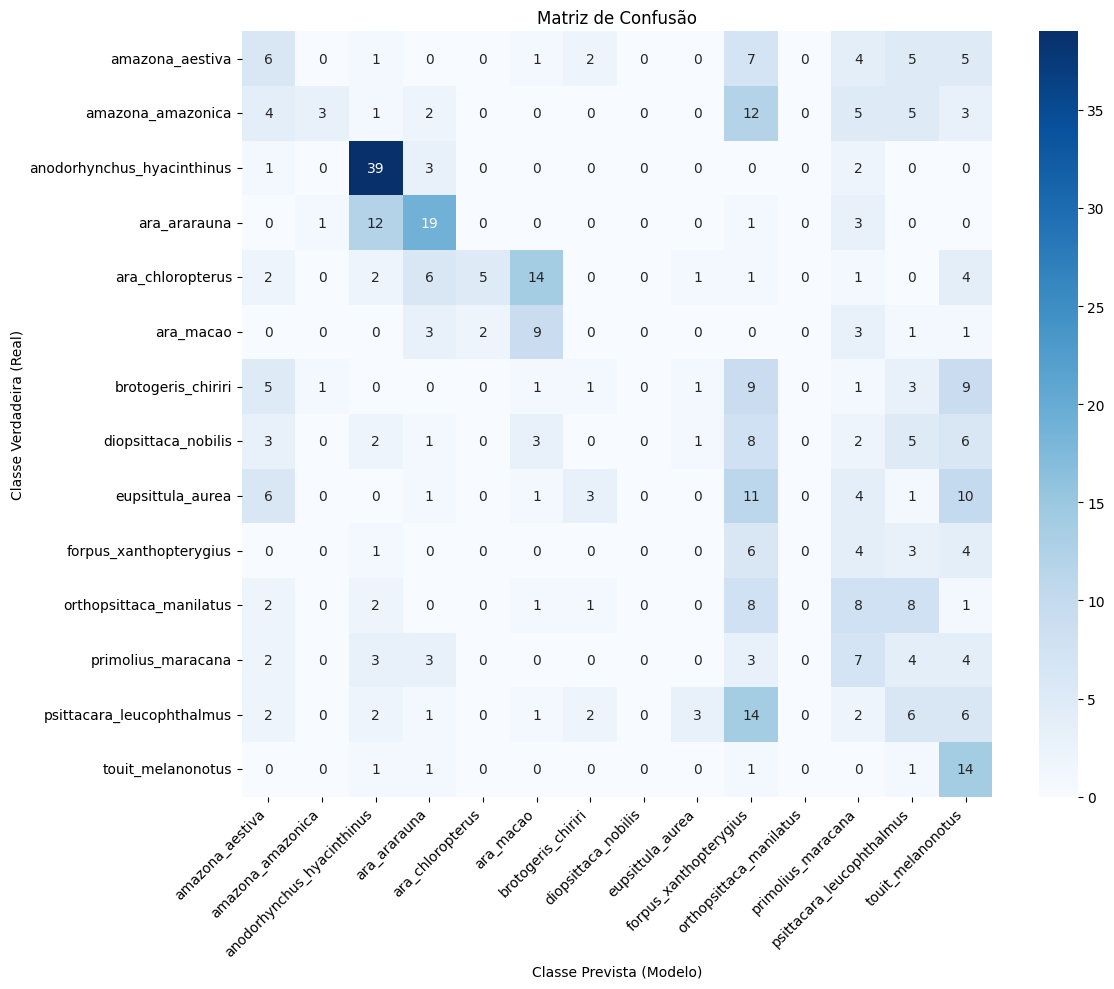

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm


def evaluate_model(model, dataloader, device, class_names, report_path=None, matrix_path=None):

    model.eval()
    all_labels = []
    all_preds = []

    print("Iniciando avaliação no conjunto de teste...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Avaliando"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_preds)
    accuracy_text = f"[ RESULTADO ] Acurácia Geral no Conjunto de Teste: {accuracy * 100:.2f}%\n"
    print(f"\n{accuracy_text}")


    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("[ RELATÓRIO DE CLASSIFICAÇÃO ]\n")
    print(report)


    if report_path:
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, 'w') as f:
            f.write(accuracy_text)
            f.write("[ RELATÓRIO DE CLASSIFICAÇÃO ]\n\n")
            f.write(report)
        print(f"✔ Relatório de classificação salvo em: {report_path}")


    print("\n[ MATRIZ DE CONFUSÃO ]\n")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.ylabel('Classe Verdadeira (Real)')
    plt.xlabel('Classe Prevista (Modelo)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()


    if matrix_path:
        os.makedirs(os.path.dirname(matrix_path), exist_ok=True)
        plt.savefig(matrix_path, dpi=300)
        print(f"✔ Matriz de confusão salva em: {matrix_path}")

    plt.show()



model_to_evaluate = ResNet56(num_classes=NUM_CLASSES)


model_path = '/content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_resnet56_scratch.pth'


model_to_evaluate.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_to_evaluate.to(device)


class_names = train_dataset.classes

results_folder = '/content/drive/MyDrive/Dataset_Aves/Resultados_Aves/'
report_save_path = os.path.join(results_folder, 'relatorio_classificacao_resnet56.txt')
matrix_save_path = os.path.join(results_folder, 'matriz_confusao_resnet56.png')

evaluate_model(model=model_to_evaluate,
               dataloader=test_loader,
               device=device,
               class_names=class_names,
               report_path=report_save_path,
               matrix_path=matrix_save_path
              )

## **Transfer Learning extrator de características**

No aprendizado por transferência (Transfer learning) você apenas retira as camadas que não deseja de uma rede pronta e coloca novas camadas sobre esta rede, treinando apenas estas novas camadas.

### **Carregar o Modelo Pré-treinado (ResNet50)**

Agora, vamos carregar a arquitetura ResNet50 que já foi treinada no dataset ImageNet. Ao carregar o modelo, o PyTorch baixará automaticamente os pesos pré-treinados.

Para Transfer Learning, geralmente queremos usar o modelo pré-treinado como um extrator de características. Isso significa que as camadas convolucionais iniciais, que aprenderam a detectar características genéricas como bordas e texturas, serão mantidas (congeladas). A camada final, que foi treinada para classificar as 1000 classes do ImageNet, será substituída para se adequar ao nosso número específico de classes de aves, no caso 14 espécies.

Começamos importando as bibliotecas necessárias, após isto fazemos a preparação dos dados e carregamento do dataset e dataloaders com um augmentation mais agressivo nos dados de treino do modelo. Já na parte de treino, foi aplicado feito o carregamento do modelo pré-treinado juntamente com o congelamento dos pesos. Na última camada foi feito a remoção da última camada da ResNet50 por uma nova com um Dropout, a função de ativação utilizada foi a SiLU que apresenta melhoras de estabilidade no treinamento e em acurácia.

Dispositivo: cuda
Caminho do modelo: /content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_feature_extractor_model.pth
Caminho dos dados: /content/drive/MyDrive/Dataset_Aves/original

Dataset dividido: 2303 para treino, 576 para validação.
Número de classes: 14

Iniciando Treinamento (Modo Extrator de Características)...
Epoch 1/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.68it/s]


train Loss: 2.1703 Acc: 0.3200


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.8199 Acc: 0.4844
-> Melhor modelo salvo! Acc: 0.4844, Loss: 1.8199
Epoch 2/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.47it/s]


train Loss: 1.9208 Acc: 0.4281


Val: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]


val Loss: 1.6823 Acc: 0.5174
-> Melhor modelo salvo! Acc: 0.5174, Loss: 1.6823
Epoch 3/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.39it/s]


train Loss: 1.8457 Acc: 0.4494


Val: 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]


val Loss: 1.6763 Acc: 0.5365
-> Melhor modelo salvo! Acc: 0.5365, Loss: 1.6763
Epoch 4/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.44it/s]


train Loss: 1.8190 Acc: 0.4620


Val: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]


val Loss: 1.6149 Acc: 0.5503
-> Melhor modelo salvo! Acc: 0.5503, Loss: 1.6149
Epoch 5/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.46it/s]


train Loss: 1.7518 Acc: 0.4889


Val: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]


val Loss: 1.5701 Acc: 0.5903
-> Melhor modelo salvo! Acc: 0.5903, Loss: 1.5701
Epoch 6/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.40it/s]


train Loss: 1.7038 Acc: 0.5124


Val: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


val Loss: 1.6386 Acc: 0.5677
Epoch 7/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 1.6667 Acc: 0.5341


Val: 100%|██████████| 18/18 [00:02<00:00,  6.94it/s]


val Loss: 1.6041 Acc: 0.5399
Epoch 8/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.80it/s]


train Loss: 1.6580 Acc: 0.5488


Val: 100%|██████████| 18/18 [00:02<00:00,  7.23it/s]


val Loss: 1.6111 Acc: 0.5417
Epoch 9/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 1.6825 Acc: 0.5258


Val: 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]


val Loss: 1.5513 Acc: 0.5799
Epoch 10/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.54it/s]


train Loss: 1.6279 Acc: 0.5480


Val: 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]


val Loss: 1.5866 Acc: 0.5712
Epoch 11/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 1.6301 Acc: 0.5480


Val: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]


val Loss: 1.5849 Acc: 0.5660
Epoch 12/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.65it/s]


train Loss: 1.6095 Acc: 0.5606


Val: 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]


val Loss: 1.5662 Acc: 0.5920
-> Melhor modelo salvo! Acc: 0.5920, Loss: 1.5662
Epoch 13/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.45it/s]


train Loss: 1.6055 Acc: 0.5597


Val: 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]


val Loss: 1.5102 Acc: 0.5851
Epoch 14/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 1.5934 Acc: 0.5758


Val: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]


val Loss: 1.5819 Acc: 0.5556
Epoch 15/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.67it/s]


train Loss: 1.5906 Acc: 0.5749


Val: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]


val Loss: 1.5323 Acc: 0.5938
-> Melhor modelo salvo! Acc: 0.5938, Loss: 1.5323
Epoch 16/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.38it/s]


train Loss: 1.5562 Acc: 0.5775


Val: 100%|██████████| 18/18 [00:02<00:00,  7.23it/s]


val Loss: 1.5729 Acc: 0.5868
Epoch 17/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.74it/s]


train Loss: 1.5442 Acc: 0.5866


Val: 100%|██████████| 18/18 [00:02<00:00,  7.30it/s]


val Loss: 1.5027 Acc: 0.5972
-> Melhor modelo salvo! Acc: 0.5972, Loss: 1.5027
Epoch 18/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.39it/s]


train Loss: 1.5626 Acc: 0.5862


Val: 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]


val Loss: 1.4874 Acc: 0.6059
-> Melhor modelo salvo! Acc: 0.6059, Loss: 1.4874
Epoch 19/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.46it/s]


train Loss: 1.5209 Acc: 0.5953


Val: 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]


val Loss: 1.5319 Acc: 0.5920
Epoch 20/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.70it/s]


train Loss: 1.5199 Acc: 0.5914


Val: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]


val Loss: 1.5222 Acc: 0.6094
-> Melhor modelo salvo! Acc: 0.6094, Loss: 1.5222
Epoch 21/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.49it/s]


train Loss: 1.5466 Acc: 0.5866


Val: 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]


val Loss: 1.5105 Acc: 0.5885
Epoch 22/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.80it/s]


train Loss: 1.5248 Acc: 0.5979


Val: 100%|██████████| 18/18 [00:02<00:00,  7.35it/s]


val Loss: 1.4550 Acc: 0.6441
-> Melhor modelo salvo! Acc: 0.6441, Loss: 1.4550
Epoch 23/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.43it/s]


train Loss: 1.5307 Acc: 0.5927


Val: 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


val Loss: 1.4649 Acc: 0.6302
Epoch 24/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.81it/s]


train Loss: 1.5212 Acc: 0.6040


Val: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


val Loss: 1.5721 Acc: 0.5694
Epoch 25/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.84it/s]


train Loss: 1.5077 Acc: 0.6092


Val: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


val Loss: 1.4737 Acc: 0.6146
Epoch 26/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 1.4734 Acc: 0.6214


Val: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]


val Loss: 1.4626 Acc: 0.6250
Epoch 27/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 1.4601 Acc: 0.6218


Val: 100%|██████████| 18/18 [00:02<00:00,  7.26it/s]


val Loss: 1.4862 Acc: 0.6059
Epoch 28/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.75it/s]


train Loss: 1.4662 Acc: 0.6270


Val: 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]


val Loss: 1.4912 Acc: 0.5990
Epoch 29/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.85it/s]


train Loss: 1.4006 Acc: 0.6622


Val: 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


val Loss: 1.4292 Acc: 0.6302
Epoch 30/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 1.3817 Acc: 0.6626


Val: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]


val Loss: 1.4029 Acc: 0.6372
Epoch 31/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 1.3617 Acc: 0.6874


Val: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]


val Loss: 1.4061 Acc: 0.6372
Epoch 32/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 1.3797 Acc: 0.6761


Val: 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]


val Loss: 1.4049 Acc: 0.6389
Epoch 33/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 1.3739 Acc: 0.6769


Val: 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]


val Loss: 1.3959 Acc: 0.6441
-> Melhor modelo salvo! Acc: 0.6441, Loss: 1.3959
Epoch 34/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.38it/s]


train Loss: 1.3255 Acc: 0.6874


Val: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]


val Loss: 1.4035 Acc: 0.6372
Epoch 35/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.48it/s]


train Loss: 1.3781 Acc: 0.6657


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.4212 Acc: 0.6337
Epoch 36/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.63it/s]


train Loss: 1.3534 Acc: 0.6730


Val: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]


val Loss: 1.4110 Acc: 0.6406
Epoch 37/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.64it/s]


train Loss: 1.3274 Acc: 0.6887


Val: 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]


val Loss: 1.3870 Acc: 0.6562
-> Melhor modelo salvo! Acc: 0.6562, Loss: 1.3870
Epoch 38/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.44it/s]


train Loss: 1.3287 Acc: 0.6930


Val: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


val Loss: 1.4076 Acc: 0.6337
Epoch 39/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.75it/s]


train Loss: 1.3365 Acc: 0.6882


Val: 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]


val Loss: 1.4132 Acc: 0.6493
Epoch 40/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 1.3203 Acc: 0.7000


Val: 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]


val Loss: 1.4359 Acc: 0.6233
Epoch 41/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 1.3227 Acc: 0.6930


Val: 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]


val Loss: 1.4127 Acc: 0.6337
Epoch 42/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 1.3282 Acc: 0.6939


Val: 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]


val Loss: 1.3912 Acc: 0.6424
Epoch 43/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.86it/s]


train Loss: 1.2929 Acc: 0.7099


Val: 100%|██████████| 18/18 [00:02<00:00,  6.77it/s]


val Loss: 1.4130 Acc: 0.6441
Epoch 44/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.75it/s]


train Loss: 1.3127 Acc: 0.7086


Val: 100%|██████████| 18/18 [00:02<00:00,  7.37it/s]


val Loss: 1.4064 Acc: 0.6510
Epoch 45/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.83it/s]


train Loss: 1.2937 Acc: 0.7069


Val: 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]


val Loss: 1.4074 Acc: 0.6424
Epoch 46/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.74it/s]


train Loss: 1.3033 Acc: 0.7030


Val: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


val Loss: 1.4036 Acc: 0.6441
Epoch 47/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.84it/s]


train Loss: 1.3107 Acc: 0.6900


Val: 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]


val Loss: 1.4078 Acc: 0.6406
Epoch 48/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.70it/s]


train Loss: 1.3205 Acc: 0.6891


Val: 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]


val Loss: 1.4016 Acc: 0.6354
Epoch 49/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.80it/s]


train Loss: 1.3020 Acc: 0.6908


Val: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]


val Loss: 1.4006 Acc: 0.6493
Epoch 50/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 1.2974 Acc: 0.7099


Val: 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]


val Loss: 1.3902 Acc: 0.6476

Treinamento concluído em 15m 5s
Melhor acurácia de validação: 0.6562

Gerando matriz de confusão com o melhor modelo...


Avaliando: 100%|██████████| 18/18 [00:02<00:00,  7.32it/s]


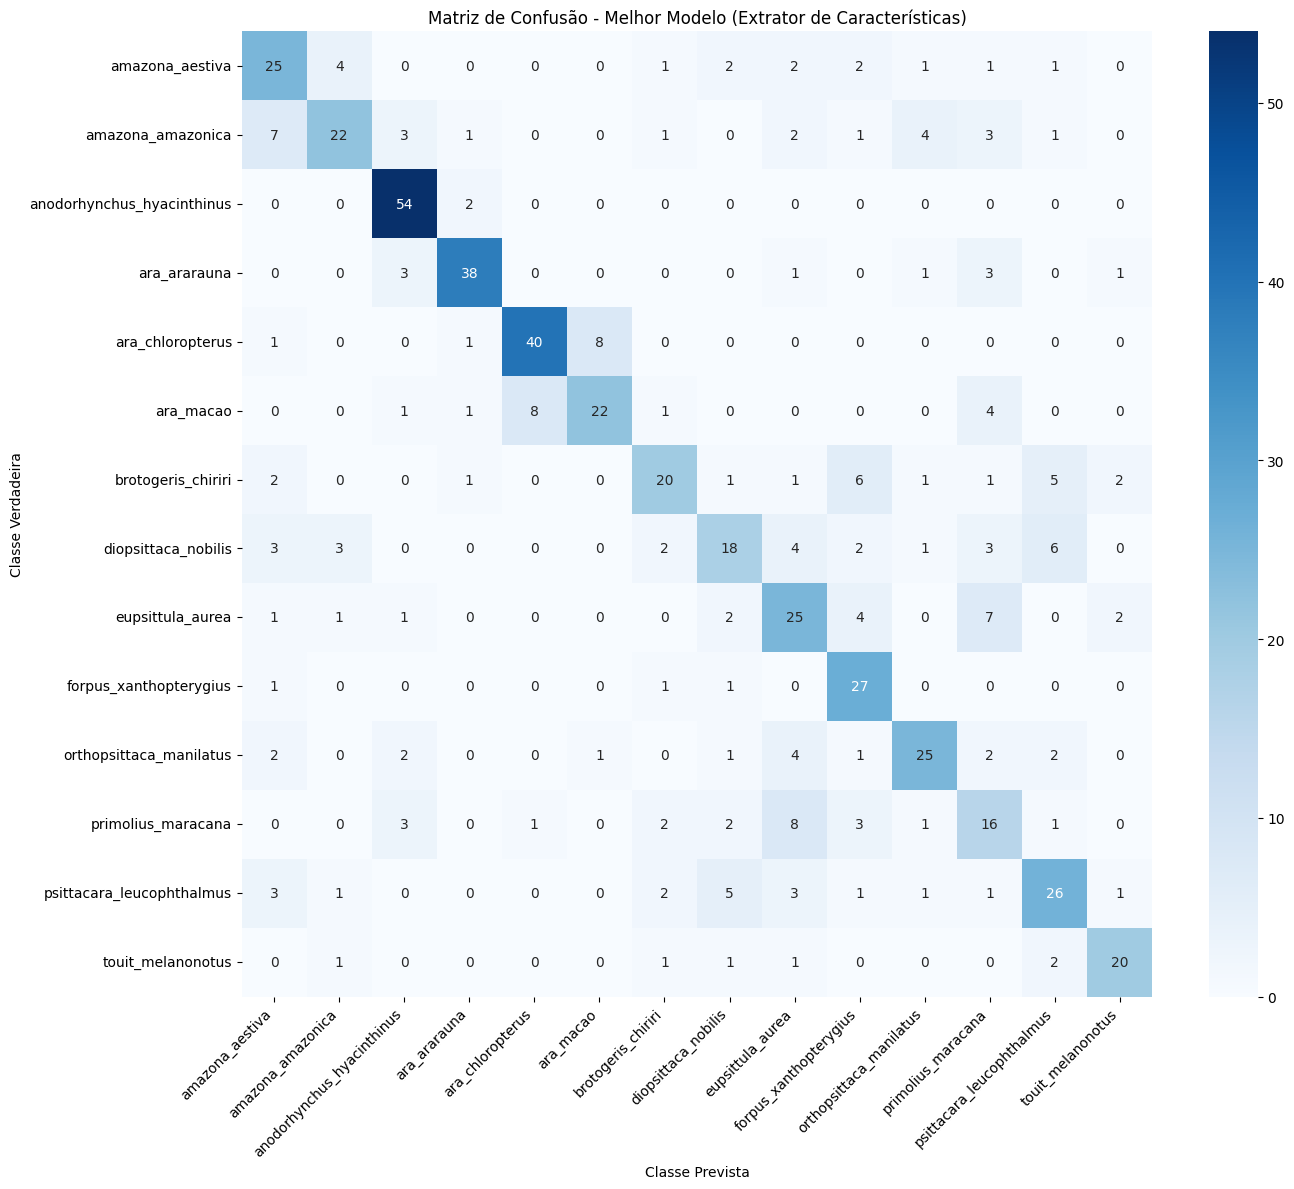

In [ ]:
# 1. IMPORTS E CONFIGURAÇÃO INICIAL
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
import copy
import time
from PIL import Image

# 2. DEFINIÇÃO DE HIPERPARÂMETROS E CAMINHOS
# --- Caminhos ---
DRIVE_PATH = '/content/drive/MyDrive/'
DATA_DIR = os.path.join(DRIVE_PATH, 'Dataset_Aves/original')
SAVE_PATH = os.path.join(DRIVE_PATH, 'Dataset_Aves/Modelos_Salvos/best_feature_extractor_model.pth')

# --- Hiperparâmetros de Treinamento ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
RANDOM_SEED = 42

# --- Configuração de Ambiente ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
print(f"Dispositivo: {device}")
print(f"Caminho do modelo: {SAVE_PATH}")
print(f"Caminho dos dados: {DATA_DIR}\n")

# 3. PIPELINE DE DADOS: TRANSFORMAÇÕES E CARREGAMENTO
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = ImageFolder(root=DATA_DIR)
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_subset_indices, val_subset_indices = random_split(full_dataset, [train_size, val_size], generator=generator)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None): self.subset, self.transform = subset, transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self): return len(self.subset)

train_dataset = TransformedSubset(train_subset_indices, transform=data_transforms['train'])
val_dataset = TransformedSubset(val_subset_indices, transform=data_transforms['val'])

num_workers = 2 if device.type == 'cuda' else 0
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
NUM_CLASSES = len(full_dataset.classes)
print(f"Dataset dividido: {dataset_sizes['train']} para treino, {dataset_sizes['val']} para validação.")
print(f"Número de classes: {NUM_CLASSES}\n")

# 4. DEFINIÇÃO DO MODELO (MODO EXTRATOR DE CARACTERÍSTICAS)
model_fe = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model_fe.parameters():
    param.requires_grad = False

num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(512, NUM_CLASSES)
)
model_fe = model_fe.to(device)

optimizer_fe = optim.AdamW(model_fe.fc.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler_fe = lr_scheduler.ReduceLROnPlateau(optimizer_fe, mode='min', factor=0.1, patience=5)

# 5. FUNÇÃO DE TREINAMENTO
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase.capitalize()}'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs); _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train': loss.backward(); optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc or (epoch_acc == best_acc and epoch_loss < best_loss):
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), SAVE_PATH)
                    print(f'-> Melhor modelo salvo! Acc: {best_acc:.4f}, Loss: {best_loss:.4f}')

    time_elapsed = time.time() - start_time
    print(f'\nTreinamento concluído em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Melhor acurácia de validação: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# 6. EXECUÇÃO
print("Iniciando Treinamento (Modo Extrator de Características)...")
model_trained = train_model(model_fe, criterion, optimizer_fe, scheduler_fe, num_epochs=NUM_EPOCHS)

# 7. AVALIAÇÃO FINAL
print("\nGerando matriz de confusão com o melhor modelo...")
y_pred, y_true = [], []
model_trained.eval()
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['val'], desc="Avaliando"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_trained(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title('Matriz de Confusão - Melhor Modelo (Extrator de Características)')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Fine Tuning**

O Fine tuning, é uma técnica de Transfer Learning onde um modelo pré-treinado é refinado

Dispositivo: cuda
Caminho do modelo: /content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_finetuning_model.pth
Caminho dos dados: /content/drive/MyDrive/Dataset_Aves/original

Dataset dividido: 2303 para treino, 576 para validação.
Número de classes: 14

Iniciando Fine-Tuning do modelo...
Epoch 1/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.66it/s]


train Loss: 2.0858 Acc: 0.3508


Val: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


val Loss: 1.6465 Acc: 0.5330
-> Melhor modelo salvo com acurácia: 0.5330
Epoch 2/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.18it/s]


train Loss: 1.7130 Acc: 0.5054


Val: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


val Loss: 1.4953 Acc: 0.6163
-> Melhor modelo salvo com acurácia: 0.6163
Epoch 3/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.21it/s]


train Loss: 1.5393 Acc: 0.5970


Val: 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]


val Loss: 1.3456 Acc: 0.6858
-> Melhor modelo salvo com acurácia: 0.6858
Epoch 4/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.22it/s]


train Loss: 1.4687 Acc: 0.6257


Val: 100%|██████████| 18/18 [00:02<00:00,  7.36it/s]


val Loss: 1.2381 Acc: 0.7257
-> Melhor modelo salvo com acurácia: 0.7257
Epoch 5/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.25it/s]


train Loss: 1.3448 Acc: 0.6813


Val: 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]


val Loss: 1.2572 Acc: 0.7309
-> Melhor modelo salvo com acurácia: 0.7309
Epoch 6/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.21it/s]


train Loss: 1.3378 Acc: 0.6813


Val: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]


val Loss: 1.1697 Acc: 0.7604
-> Melhor modelo salvo com acurácia: 0.7604
Epoch 7/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.19it/s]


train Loss: 1.2716 Acc: 0.7060


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.1759 Acc: 0.7517
Epoch 8/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 1.2316 Acc: 0.7260


Val: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


val Loss: 1.2045 Acc: 0.7483
Epoch 9/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.71it/s]


train Loss: 1.2030 Acc: 0.7425


Val: 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]


val Loss: 1.1576 Acc: 0.7604
Epoch 10/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 1.2052 Acc: 0.7373


Val: 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]


val Loss: 1.1519 Acc: 0.7760
-> Melhor modelo salvo com acurácia: 0.7760
Epoch 11/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.22it/s]


train Loss: 1.1468 Acc: 0.7673


Val: 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


val Loss: 1.0903 Acc: 0.7847
-> Melhor modelo salvo com acurácia: 0.7847
Epoch 12/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.17it/s]


train Loss: 1.1210 Acc: 0.7664


Val: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]


val Loss: 1.1235 Acc: 0.7708
Epoch 13/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.81it/s]


train Loss: 1.1208 Acc: 0.7777


Val: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]


val Loss: 1.1561 Acc: 0.7708
Epoch 14/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 1.1031 Acc: 0.7799


Val: 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]


val Loss: 1.1092 Acc: 0.7778
Epoch 15/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 1.0804 Acc: 0.8020


Val: 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]


val Loss: 1.1482 Acc: 0.7847
Epoch 16/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 1.0607 Acc: 0.8046


Val: 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]


val Loss: 1.0774 Acc: 0.7847
Epoch 17/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 1.0511 Acc: 0.8098


Val: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]


val Loss: 1.0564 Acc: 0.8003
-> Melhor modelo salvo com acurácia: 0.8003
Epoch 18/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.16it/s]


train Loss: 1.0221 Acc: 0.8185


Val: 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]


val Loss: 1.1131 Acc: 0.7865
Epoch 19/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 1.0417 Acc: 0.8029


Val: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]


val Loss: 1.1124 Acc: 0.7812
Epoch 20/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.80it/s]


train Loss: 1.0086 Acc: 0.8259


Val: 100%|██████████| 18/18 [00:02<00:00,  7.32it/s]


val Loss: 1.1309 Acc: 0.7674
Epoch 21/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.74it/s]


train Loss: 1.0041 Acc: 0.8315


Val: 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]


val Loss: 1.1649 Acc: 0.7517
Epoch 22/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.74it/s]


train Loss: 0.9919 Acc: 0.8337


Val: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]


val Loss: 1.0928 Acc: 0.7847
Epoch 23/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 0.9899 Acc: 0.8294


Val: 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]


val Loss: 1.1323 Acc: 0.7882
Epoch 24/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 0.9348 Acc: 0.8597


Val: 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]


val Loss: 1.0570 Acc: 0.8003
Epoch 25/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.85it/s]


train Loss: 0.8978 Acc: 0.8732


Val: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


val Loss: 1.0252 Acc: 0.8229
-> Melhor modelo salvo com acurácia: 0.8229
Epoch 26/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.23it/s]


train Loss: 0.8849 Acc: 0.8767


Val: 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]


val Loss: 1.0208 Acc: 0.8229
Epoch 27/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.81it/s]


train Loss: 0.8629 Acc: 0.8858


Val: 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]


val Loss: 1.0063 Acc: 0.8212
Epoch 28/50
----------


Train: 100%|██████████| 72/72 [00:14<00:00,  4.82it/s]


train Loss: 0.8767 Acc: 0.8749


Val: 100%|██████████| 18/18 [00:02<00:00,  7.39it/s]


val Loss: 1.0108 Acc: 0.8177
Epoch 29/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 0.8877 Acc: 0.8749


Val: 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]


val Loss: 1.0111 Acc: 0.8229
Epoch 30/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 0.8525 Acc: 0.8849


Val: 100%|██████████| 18/18 [00:02<00:00,  7.32it/s]


val Loss: 1.0191 Acc: 0.8177
Epoch 31/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.72it/s]


train Loss: 0.8646 Acc: 0.8845


Val: 100%|██████████| 18/18 [00:02<00:00,  7.29it/s]


val Loss: 1.0270 Acc: 0.8160
Epoch 32/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 0.8458 Acc: 0.8980


Val: 100%|██████████| 18/18 [00:02<00:00,  7.26it/s]


val Loss: 1.0105 Acc: 0.8229
Epoch 33/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 0.8407 Acc: 0.8927


Val: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]


val Loss: 1.0193 Acc: 0.8177
Epoch 34/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.79it/s]


train Loss: 0.8337 Acc: 0.8906


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.0154 Acc: 0.8247
-> Melhor modelo salvo com acurácia: 0.8247
Epoch 35/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.18it/s]


train Loss: 0.8289 Acc: 0.9006


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.0156 Acc: 0.8229
Epoch 36/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s]


train Loss: 0.8324 Acc: 0.8997


Val: 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]


val Loss: 1.0143 Acc: 0.8264
-> Melhor modelo salvo com acurácia: 0.8264
Epoch 37/50
----------


Train: 100%|██████████| 72/72 [00:16<00:00,  4.24it/s]


train Loss: 0.8594 Acc: 0.8828


Val: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


val Loss: 1.0142 Acc: 0.8281
-> Melhor modelo salvo com acurácia: 0.8281
Epoch 38/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.23it/s]


train Loss: 0.8280 Acc: 0.9010


Val: 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]


val Loss: 1.0218 Acc: 0.8229
Epoch 39/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.74it/s]


train Loss: 0.8429 Acc: 0.8910


Val: 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]


val Loss: 1.0144 Acc: 0.8247
Epoch 40/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 0.8214 Acc: 0.9058


Val: 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]


val Loss: 1.0122 Acc: 0.8264
Epoch 41/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 0.8496 Acc: 0.8845


Val: 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]


val Loss: 1.0107 Acc: 0.8194
Epoch 42/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 0.8330 Acc: 0.8975


Val: 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


val Loss: 1.0097 Acc: 0.8212
Epoch 43/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 0.8209 Acc: 0.9010


Val: 100%|██████████| 18/18 [00:02<00:00,  7.31it/s]


val Loss: 1.0157 Acc: 0.8316
-> Melhor modelo salvo com acurácia: 0.8316
Epoch 44/50
----------


Train: 100%|██████████| 72/72 [00:17<00:00,  4.20it/s]


train Loss: 0.8433 Acc: 0.8888


Val: 100%|██████████| 18/18 [00:02<00:00,  7.37it/s]


val Loss: 1.0161 Acc: 0.8264
Epoch 45/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


train Loss: 0.8298 Acc: 0.9019


Val: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]


val Loss: 1.0162 Acc: 0.8316
Epoch 46/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.69it/s]


train Loss: 0.8389 Acc: 0.8945


Val: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


val Loss: 1.0149 Acc: 0.8212
Epoch 47/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.78it/s]


train Loss: 0.8368 Acc: 0.8945


Val: 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]


val Loss: 1.0207 Acc: 0.8281
Epoch 48/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.67it/s]


train Loss: 0.8316 Acc: 0.8914


Val: 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]


val Loss: 1.0203 Acc: 0.8281
Epoch 49/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 0.8409 Acc: 0.8914


Val: 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]


val Loss: 1.0182 Acc: 0.8247
Epoch 50/50
----------


Train: 100%|██████████| 72/72 [00:15<00:00,  4.77it/s]


train Loss: 0.8382 Acc: 0.8962


Val: 100%|██████████| 18/18 [00:02<00:00,  6.85it/s]


val Loss: 1.0149 Acc: 0.8264

Treinamento concluído em 15m 19s
Melhor acurácia de validação: 0.8316

Gerando matriz de confusão com o melhor modelo...


Avaliando: 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]


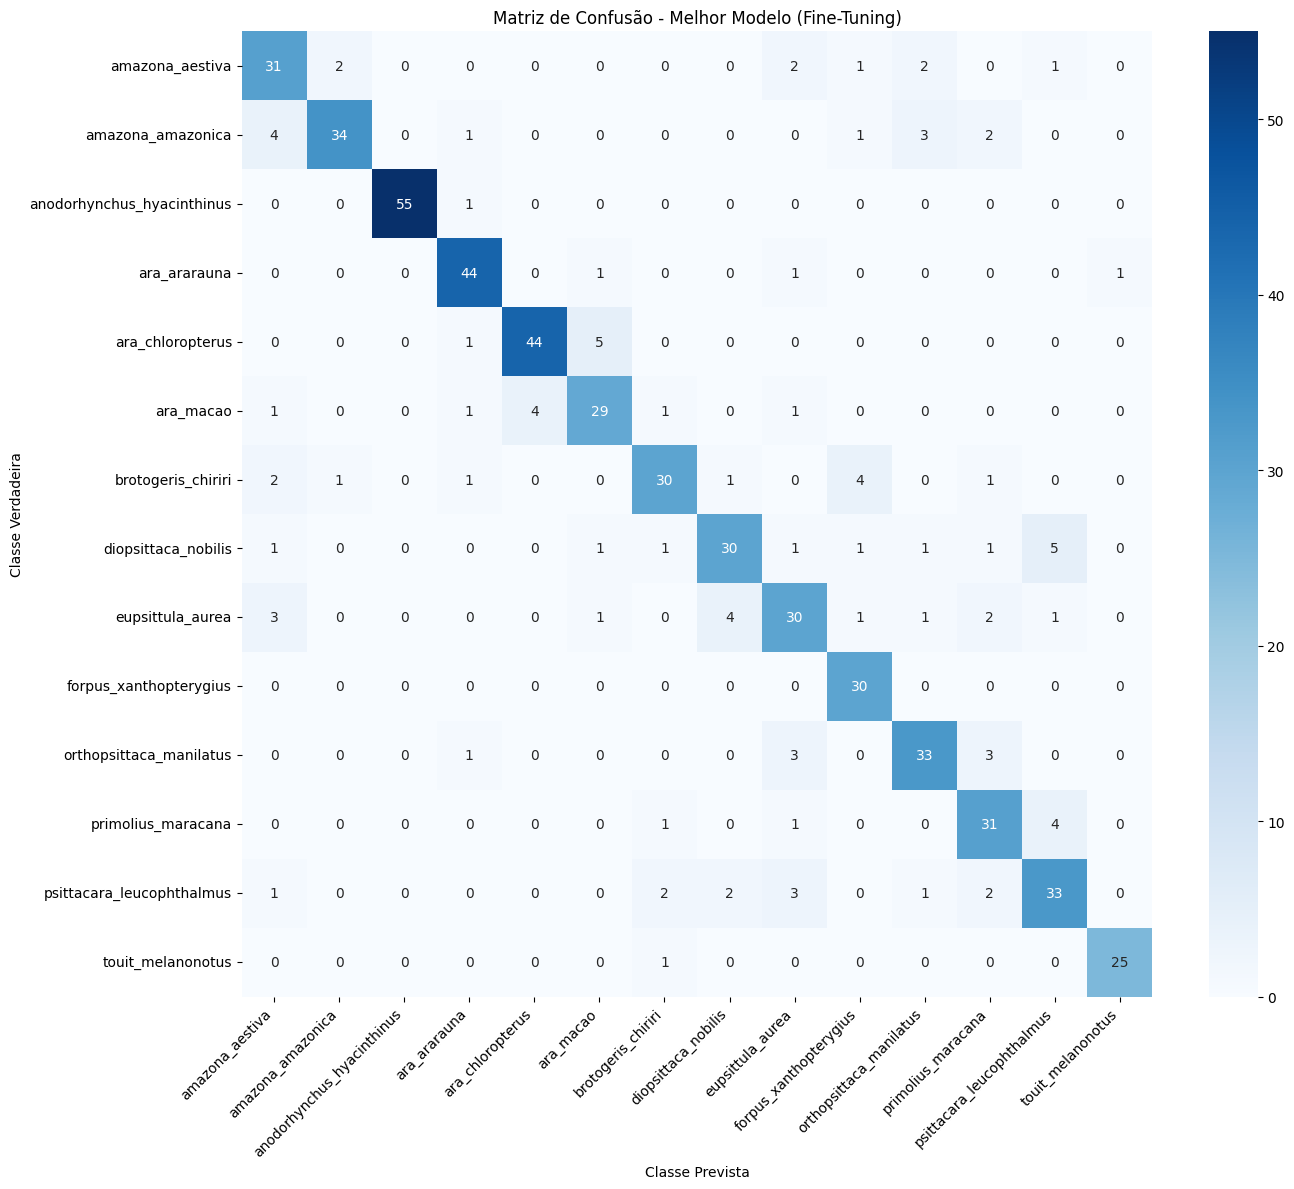

In [ ]:
# 1. IMPORTS E CONFIGURAÇÃO INICIAL
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
import copy
import time
from PIL import Image

# 2. DEFINIÇÃO DE HIPERPARÂMETROS E CAMINHOS
# --- Caminhos ---
DRIVE_PATH = '/content/drive/MyDrive/'
DATA_DIR = os.path.join(DRIVE_PATH, 'Dataset_Aves/original')
SAVE_PATH = os.path.join(DRIVE_PATH, 'Dataset_Aves/Modelos_Salvos/best_finetuning_model.pth')

# --- Hiperparâmetros de Treinamento ---
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR_HEAD = 1e-3
LR_BODY = 1e-4
TRAIN_SPLIT = 0.8
RANDOM_SEED = 42

# --- Configuração de Ambiente ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
print(f"Dispositivo: {device}")
print(f"Caminho do modelo: {SAVE_PATH}")
print(f"Caminho dos dados: {DATA_DIR}\n")

# 3. PIPELINE DE DADOS: TRANSFORMAÇÕES E CARREGAMENTO
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = ImageFolder(root=DATA_DIR)
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_subset_indices, val_subset_indices = random_split(full_dataset, [train_size, val_size], generator=generator)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None): self.subset, self.transform = subset, transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self): return len(self.subset)

train_dataset = TransformedSubset(train_subset_indices, transform=data_transforms['train'])
val_dataset = TransformedSubset(val_subset_indices, transform=data_transforms['val'])

num_workers = 2 if device.type == 'cuda' else 0
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
NUM_CLASSES = len(full_dataset.classes)
print(f"Dataset dividido: {dataset_sizes['train']} para treino, {dataset_sizes['val']} para validação.")
print(f"Número de classes: {NUM_CLASSES}\n")

# 4. DEFINIÇÃO DO MODELO E CONFIGURAÇÃO DE FINE-TUNING
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.layer4.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(512, NUM_CLASSES)
)
model_ft = model_ft.to(device)

optimizer_ft = optim.AdamW([
    {'params': model_ft.fc.parameters(), 'lr': LR_HEAD},
    {'params': model_ft.layer4.parameters(), 'lr': LR_BODY}
])

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler_ft = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=5)

# 5. FUNÇÃO DE TREINAMENTO
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase.capitalize()}'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs); _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward(); optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), SAVE_PATH)
                    print(f'-> Melhor modelo salvo com acurácia: {best_acc:.4f}')

    time_elapsed = time.time() - start_time
    print(f'\nTreinamento concluído em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Melhor acurácia de validação: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# 6. EXECUÇÃO
print("Iniciando Fine-Tuning do modelo...")
model_trained = train_model(model_ft, criterion, optimizer_ft, scheduler_ft, num_epochs=NUM_EPOCHS)

# 7. AVALIAÇÃO FINAL
print("\nGerando matriz de confusão com o melhor modelo...")
y_pred, y_true = [], []
model_trained.eval()
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['val'], desc="Avaliando"):
        # 1. Mover os dados para o device correto
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Passar os dados (já na GPU) para o modelo
        outputs = model_trained(inputs)

        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title('Matriz de Confusão - Melhor Modelo (Fine-Tuning)')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Validação de modelos**

**Para esta parte de validação dos modelos, utilizamos um dataset externo e utilizamos os modelos para as detecções.**

Nesta célula, começamos importando o dataset que utilizaremos para validar os modelos.

In [ ]:
from google.colab import drive
import os
from pathlib import Path

# Montar o Google Drive
drive.mount('/content/drive')

# Definindo o caminho para a pasta
Path_Validacao = '/content/drive/MyDrive/DatasetVALIDACAO'

# Caminho para saída
output_path = '/content/drive/MyDrive/Dataset_Aves/Validacao_Modelos'

# Verificar se o dataset existe
if os.path.exists(Path_Validacao):
    print(f"Dataset encontrado em: {Path_Validacao}")

    # Listar as espécies disponíveis
    species = [d for d in os.listdir(Path_Validacao) if os.path.isdir(os.path.join(Path_Validacao, d))]
    print(f"Espécies encontradas ({len(species)}): {species}")

    # Contar imagens por espécie
    total_images = 0
    for specie in species:
        specie_path = os.path.join(Path_Validacao, specie)
        img_count = len([f for f in os.listdir(specie_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   {specie}: {img_count} imagens")
        total_images += img_count

    print(f"\nTotal de imagens no dataset: {total_images}")
    print(f"Pasta de entrada: {Path_Validacao}")
    print(f"Pasta de saída: {output_path}")

else:
    print(f"Dataset não encontrado em: {Path_Validacao}")
    print("Verifique o caminho do dataset")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset encontrado em: /content/drive/MyDrive/DatasetVALIDACAO
Espécies encontradas (14): ['amazona_amazonica', 'ara_macao', 'amazona_aestiva', 'primolius_maracana', 'forpus_xanthopterygius', 'anodorhynchus_hyacinthinus', 'diopsittaca_nobilis', 'brotogeris_chiriri', 'psittacara_leucophthalmus', 'ara_ararauna', 'touit_melanonotus', 'eupsittula_aurea', 'ara_chloropterus', 'orthopsittaca_manilatus']
   amazona_amazonica: 201 imagens
   ara_macao: 216 imagens
   amazona_aestiva: 250 imagens
   primolius_maracana: 220 imagens
   forpus_xanthopterygius: 218 imagens
   anodorhynchus_hyacinthinus: 250 imagens
   diopsittaca_nobilis: 231 imagens
   brotogeris_chiriri: 200 imagens
   psittacara_leucophthalmus: 222 imagens
   ara_ararauna: 250 imagens
   touit_melanonotus: 150 imagens
   eupsittula_aurea: 218 imagens
   ara_chloropterus: 211 imagens
   orthopsittaca_man

Nesta parte, validamos a ResNET56 criada a cada layer utilizando os dados de validação.

--- Carregando o modelo ---
Dispositivo de execução: cuda
Arquitetura do modelo criada.
Pesos carregados com sucesso de: /content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_resnet56_scratch.pth
Modelo em modo de avaliação (model.eval()) pronto para inferência.
--------------------------

Dataset de validação carregado de: /content/drive/MyDrive/DatasetVALIDACAO
Número de imagens para validar: 3037
Classes encontradas: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']

Iniciando a validação no dataset externo...


Gerando Previsões: 100%|██████████| 95/95 [00:12<00:00,  7.85it/s]


Validação concluída.

--- Relatório de Classificação ---
                            precision    recall  f1-score   support

           amazona_aestiva       0.19      0.14      0.16       250
         amazona_amazonica       0.23      0.07      0.11       201
anodorhynchus_hyacinthinus       0.53      0.84      0.65       250
              ara_ararauna       0.39      0.44      0.41       250
          ara_chloropterus       0.51      0.19      0.28       211
                 ara_macao       0.49      0.50      0.49       216
        brotogeris_chiriri       0.22      0.06      0.09       200
       diopsittaca_nobilis       0.12      0.01      0.02       231
          eupsittula_aurea       0.14      0.03      0.05       218
    forpus_xanthopterygius       0.12      0.33      0.18       218
   orthopsittaca_manilatus       0.00      0.00      0.00       200
        primolius_maracana       0.18      0.27      0.22       220
 psittacara_leucophthalmus       0.15      0.16      0.16 

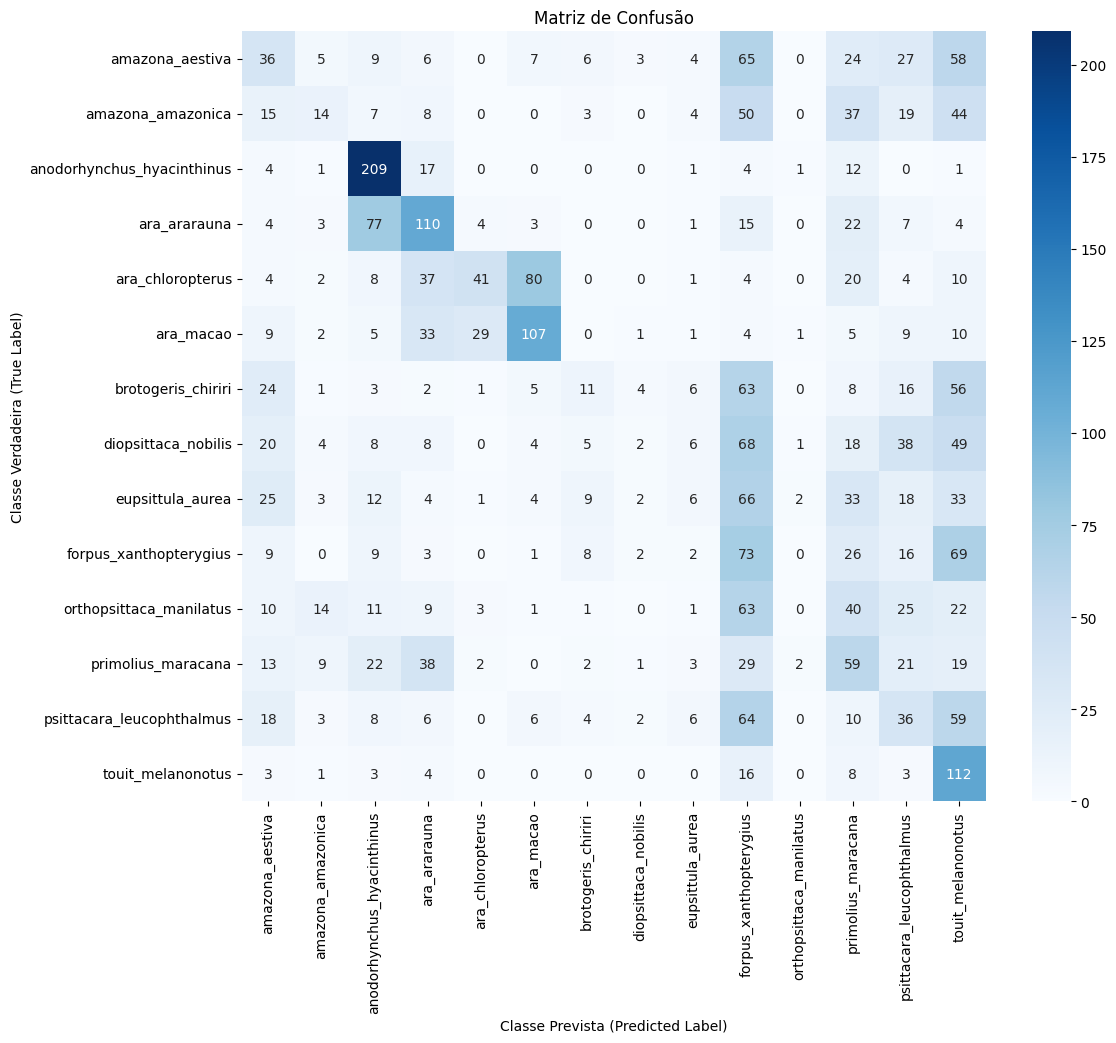

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Definição do Bloco Residual Básico (BasicBlock)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.silu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=14):
        super(ResNet, self).__init__()
        self.in_planes = 16

        # A camada inicial é crucial. Para imagens 224x224, uma conv maior
        # com stride poderia ser melhor, mas vamos manter a sua para a
        # abordagem "do zero". Esta também funciona.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

def ResNet56(num_classes):
    return ResNet(BasicBlock, [9, 9, 9], num_classes=num_classes)


# PARTE 2: CARREGAMENTO DO MODELO SALVO

# --- Configurações Iniciais ---
NUM_CLASSES = 14 # Qtd de pássaros
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Caminho para o Modelo Salvo ---
PATH_DO_MODELO_SALVO = '/content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_resnet56_scratch.pth'

# --- Carregando o Modelo ---
print("--- Carregando o modelo ---")
print(f"Dispositivo de execução: {DEVICE}")



# 1. Crie uma instância da arquitetura do seu modelo
#    (A classe ResNet56 precisa estar definida como na Parte 1)
model = ResNet56(num_classes=NUM_CLASSES)
print("Arquitetura do modelo criada.")

# 2. Carregue os pesos (o 'state_dict') do arquivo salvo
#    O map_location garante que funcione mesmo que você treinou na GPU e agora usa CPU
model.load_state_dict(torch.load(PATH_DO_MODELO_SALVO, map_location=DEVICE))
print(f"Pesos carregados com sucesso de: {PATH_DO_MODELO_SALVO}")

# 3. Mova o modelo para o dispositivo (GPU ou CPU)
model.to(DEVICE)

# 4. **MUITO IMPORTANTE**: Coloque o modelo em modo de avaliação
#    Isso desativa camadas como Dropout e usa as médias/variâncias do BatchNorm
model.eval()
print("Modelo em modo de avaliação (model.eval()) pronto para inferência.")
print("--------------------------\n")

# PARTE 3: PREPARAÇÃO DO DATASET DE VALIDAÇÃO

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Caminho para seu dataset de validação ---
Path_Validacao = '/content/drive/MyDrive/DatasetVALIDACAO'

# --- Definição das Transformações de Validação ---
# Os valores abaixo estão corretos e são o padrão para modelos pré-treinados no ImageNet.
# Eles garantem que suas imagens sejam processadas da mesma forma que o modelo foi treinado.
validation_transforms = transforms.Compose([
    # 1. Redimensiona todas as imagens para 224x224 pixels.
    transforms.Resize((224, 224)),

    # 2. Converte as imagens de formato PIL para Tensores PyTorch.
    transforms.ToTensor(),

    # 3. Normaliza os tensores usando a média e o desvio padrão do ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregue o dataset de validação usando ImageFolder, aplicando as transformações definidas
validation_dataset = datasets.ImageFolder(root=Path_Validacao, transform=validation_transforms)

# Crie o DataLoader para carregar os dados em lotes (batches) de forma eficiente
# num_workers=2 usa processos paralelos para acelerar o carregamento dos dados
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Dataset de validação carregado de: {Path_Validacao}")
print(f"Número de imagens para validar: {len(validation_dataset)}")
print(f"Classes encontradas: {validation_dataset.classes}\n")




# =================================================================================
# PARTE 4: FUNÇÃO DE VALIDAÇÃO APRIMORADA E GERAÇÃO DE MÉTRICAS
# =================================================================================

def get_predictions_and_labels(model_to_validate, loader, device):
    """
    Função aprimorada que itera sobre o dataset e retorna listas com
    todas as previsões e todos os rótulos verdadeiros.
    """
    # Coloca o modelo em modo de avaliação
    model_to_validate.eval()

    all_predictions = []
    all_true_labels = []

    # Desativa o cálculo de gradientes para acelerar a execução
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Gerando Previsões")
        for inputs, labels in progress_bar:
            # Mova os dados para o mesmo dispositivo do modelo
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Faça a predição
            outputs = model_to_validate(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Adicione as previsões e rótulos do batch às listas
            # .cpu().numpy() é necessário para usar com scikit-learn
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return all_true_labels, all_predictions

# --- 1. Obter as previsões do modelo no dataset de validação ---
print("Iniciando a validação no dataset externo...")
true_labels, pred_labels = get_predictions_and_labels(model, validation_loader, DEVICE)
print("Validação concluída.\n")

# --- 2. Gerar o Relatório de Classificação (Precisão, Recall, F1-Score) ---
print("--- Relatório de Classificação ---")
# Obter os nomes das classes do dataset para um relatório mais legível
class_names = validation_dataset.classes
print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))


# --- 3. Gerar e Visualizar a Matriz de Confusão ---
print("\n--- Matriz de Confusão ---")
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Usar Seaborn e Matplotlib para criar uma visualização bonita
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira (True Label)')
plt.xlabel('Classe Prevista (Predicted Label)')
plt.show()

Nesta parte, validamos a ResNET50 utilizida no Transfer Learning para extração de características  utilizando os dados de validação.

--- Carregando o modelo de Transfer Learning (ResNet50) ---
Dispositivo de execução: cuda
Arquitetura ResNet50 carregada e cabeça customizada adicionada.
Pesos do modelo de Transfer Learning carregados com sucesso de: /content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_feature_extractor_model.pth
Modelo em modo de avaliação (model.eval()) pronto para inferência.
--------------------------

Dataset de validação carregado de: /content/drive/MyDrive/DatasetVALIDACAO
Número de imagens para validar: 3037
Classes encontradas: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']

Iniciando a validação do modelo de Transfer Learning no dataset externo...


Gerando Previsões: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


Validação concluída.

--- Relatório de Classificação (Transfer Learning) ---
                            precision    recall  f1-score   support

           amazona_aestiva       0.80      0.80      0.80       250
         amazona_amazonica       0.86      0.75      0.80       201
anodorhynchus_hyacinthinus       0.91      0.99      0.95       250
              ara_ararauna       0.88      0.91      0.90       250
          ara_chloropterus       0.85      0.87      0.86       211
                 ara_macao       0.87      0.81      0.84       216
        brotogeris_chiriri       0.80      0.73      0.77       200
       diopsittaca_nobilis       0.79      0.70      0.74       231
          eupsittula_aurea       0.77      0.84      0.80       218
    forpus_xanthopterygius       0.80      0.91      0.85       218
   orthopsittaca_manilatus       0.84      0.78      0.81       200
        primolius_maracana       0.76      0.75      0.75       220
 psittacara_leucophthalmus       0.79 

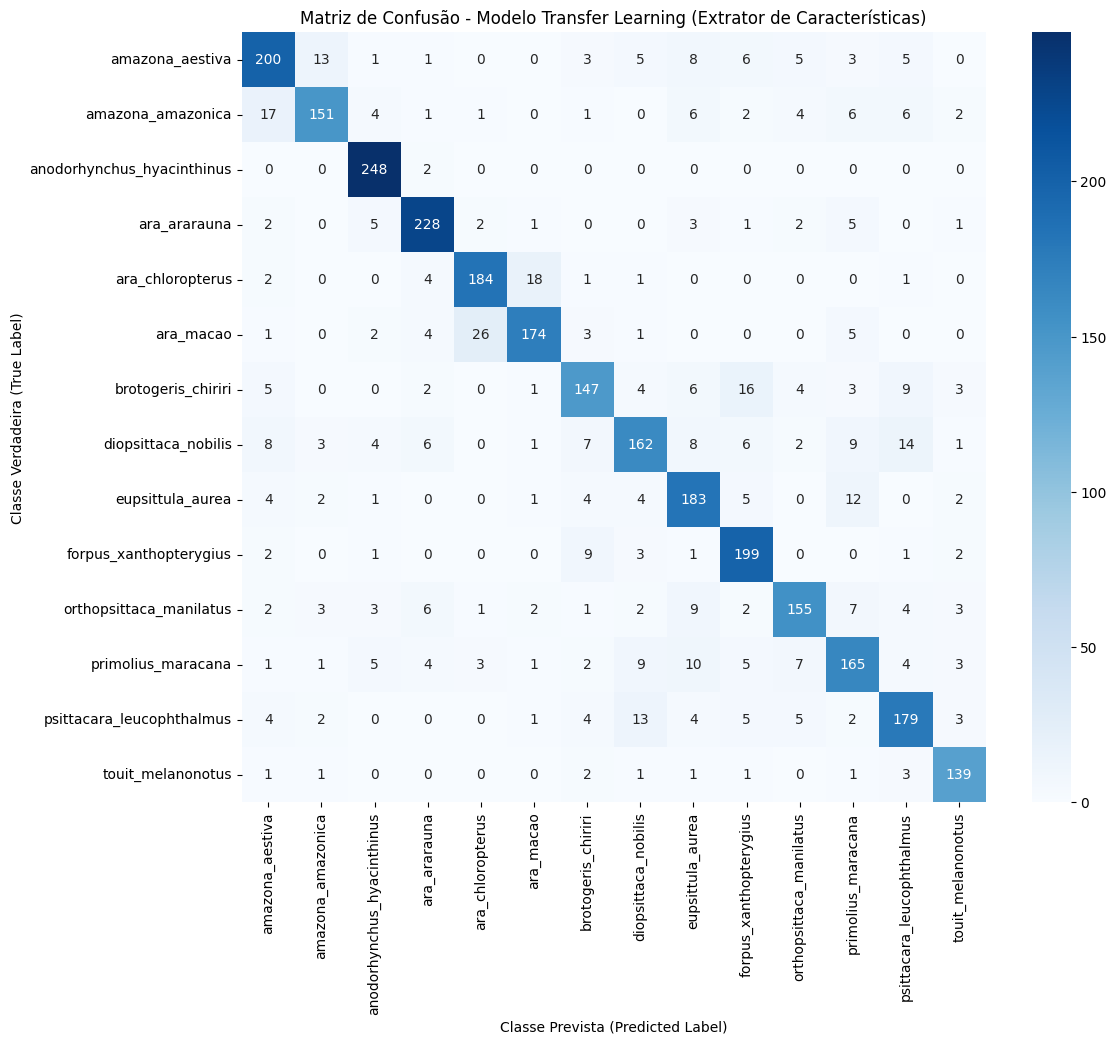

In [ ]:
# PARTE 1: IMPORTAÇÕES
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms, models # Import models
from torch.utils.data import DataLoader
import os

# PARTE 2: CARREGAMENTO DO MODELO SALVO (MODELO DE TRANSFER LEARNING)

# --- Configurações Iniciais ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Caminho para o Modelo Salvo do TREINAMENTO COM TRANSFER LEARNING ---
PATH_DO_MODELO_SALVO = '/content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_feature_extractor_model.pth'

# --- Carregando o Modelo ResNet50 e a Cabeça Customizada ---
print("--- Carregando o modelo de Transfer Learning (ResNet50) ---")
print(f"Dispositivo de execução: {DEVICE}")

# 1. Carregue a arquitetura ResNet50 pré-treinada no ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # Carrega a arquitetura ResNet50

# 2. Substitua a camada final (classifier head) pela cabeça customizada usada no treino
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.SiLU(),
    nn.Dropout(0.25), # Mesmo dropout do treino
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Dropout(0.25), # mesmo dropout do treino
    nn.Linear(512, NUM_CLASSES)
)
print("Arquitetura ResNet50 carregada e cabeça customizada adicionada.")


# 3. Carregue os pesos (o 'state_dict') do arquivo salvo do SEU treino
model.load_state_dict(torch.load(PATH_DO_MODELO_SALVO, map_location=DEVICE))
print(f"Pesos do modelo de Transfer Learning carregados com sucesso de: {PATH_DO_MODELO_SALVO}")

# 4. Mova o modelo para o dispositivo (GPU ou CPU)
model.to(DEVICE)

# 5. **MUITO IMPORTANTE**: Coloque o modelo em modo de avaliação
#    Isso desativa camadas como Dropout e usa as médias/variâncias do BatchNorm aprendidas
model.eval()
print("Modelo em modo de avaliação (model.eval()) pronto para inferência.")
print("--------------------------\n")

# PARTE 3: PREPARAÇÃO DO DATASET DE VALIDAÇÃO

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Caminho para o dataset de validação ---
Path_Validacao = '/content/drive/MyDrive/DatasetVALIDACAO'

# --- Definição das Transformações de Validação ---
# Os valores abaixo estão corretos e são o padrão para modelos pré-treinados no ImageNet.
# Eles garantem que suas imagens sejam processadas da mesma forma que o modelo foi treinado.
validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Carregue o dataset de validação usando ImageFolder, aplicando as transformações definidas
validation_dataset = datasets.ImageFolder(root=Path_Validacao, transform=validation_transforms)

# Crie o DataLoader para carregar os dados em lotes (batches) de forma eficiente
# num_workers=2 usa processos paralelos para acelerar o carregamento dos dados
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Dataset de validação carregado de: {Path_Validacao}")
print(f"Número de imagens para validar: {len(validation_dataset)}")
print(f"Classes encontradas: {validation_dataset.classes}\n")


# PARTE 4: FUNÇÃO DE VALIDAÇÃO E GERAÇÃO DE MÉTRICAS (JÁ EXISTENTE E CORRETA)

def get_predictions_and_labels(model_to_validate, loader, device):
    """
    Função aprimorada que itera sobre o dataset e retorna listas com
    todas as previsões e todos os rótulos verdadeiros.
    """
    # Coloca o modelo em modo de avaliação
    model_to_validate.eval()

    all_predictions = []
    all_true_labels = []

    # Desativa o cálculo de gradientes para acelerar a execução
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Gerando Previsões")
        for inputs, labels in progress_bar:
            # Mova os dados para o mesmo dispositivo do modelo
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Faça a predição
            outputs = model_to_validate(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Adicione as previsões e rótulos do batch às listas
            # .cpu().numpy() é necessário para usar com scikit-learn
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return all_true_labels, all_predictions

# --- 1. Obter as previsões do modelo no dataset de validação ---
print("Iniciando a validação do modelo de Transfer Learning no dataset externo...")
true_labels, pred_labels = get_predictions_and_labels(model, validation_loader, DEVICE)
print("Validação concluída.\n")

# --- 2. Gerar o Relatório de Classificação (Precisão, Recall, F1-Score) ---
print("--- Relatório de Classificação (Transfer Learning) ---")
# Obter os nomes das classes do dataset para um relatório mais legível
class_names = validation_dataset.classes
print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))


# --- 3. Gerar e Visualizar a Matriz de Confusão ---
print("\n--- Matriz de Confusão (Transfer Learning) ---")
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Usar Seaborn e Matplotlib para criar uma visualização bonita
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão - Modelo Transfer Learning (Extrator de Características)')
plt.ylabel('Classe Verdadeira (True Label)')
plt.xlabel('Classe Prevista (Predicted Label)')
plt.show()

Nesta parte, validaremos a ResNet treinada com fine tuning.

--- Carregando o modelo de Fine-Tuning (ResNet50) ---
Dispositivo de execução: cuda
Arquitetura ResNet50 carregada e cabeça customizada adicionada.
Pesos do modelo de Fine-Tuning carregados com sucesso de: /content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_finetuning_model.pth
Modelo em modo de avaliação (model.eval()) pronto para inferência.
--------------------------

Dataset de validação carregado de: /content/drive/MyDrive/DatasetVALIDACAO
Número de imagens para validar: 3037
Classes encontradas: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']

Iniciando a validação do modelo de Fine-Tuning no dataset externo...


Gerando Previsões: 100%|██████████| 95/95 [00:13<00:00,  7.29it/s]


Validação concluída.

--- Relatório de Classificação (Fine-Tuning) ---
                            precision    recall  f1-score   support

           amazona_aestiva       0.93      0.96      0.94       250
         amazona_amazonica       0.97      0.92      0.94       201
anodorhynchus_hyacinthinus       0.99      1.00      0.99       250
              ara_ararauna       0.94      0.98      0.96       250
          ara_chloropterus       0.88      0.94      0.91       211
                 ara_macao       0.94      0.86      0.90       216
        brotogeris_chiriri       0.96      0.90      0.93       200
       diopsittaca_nobilis       0.94      0.91      0.92       231
          eupsittula_aurea       0.91      0.94      0.93       218
    forpus_xanthopterygius       0.95      1.00      0.97       218
   orthopsittaca_manilatus       0.93      0.92      0.92       200
        primolius_maracana       0.94      0.88      0.91       220
 psittacara_leucophthalmus       0.90      0

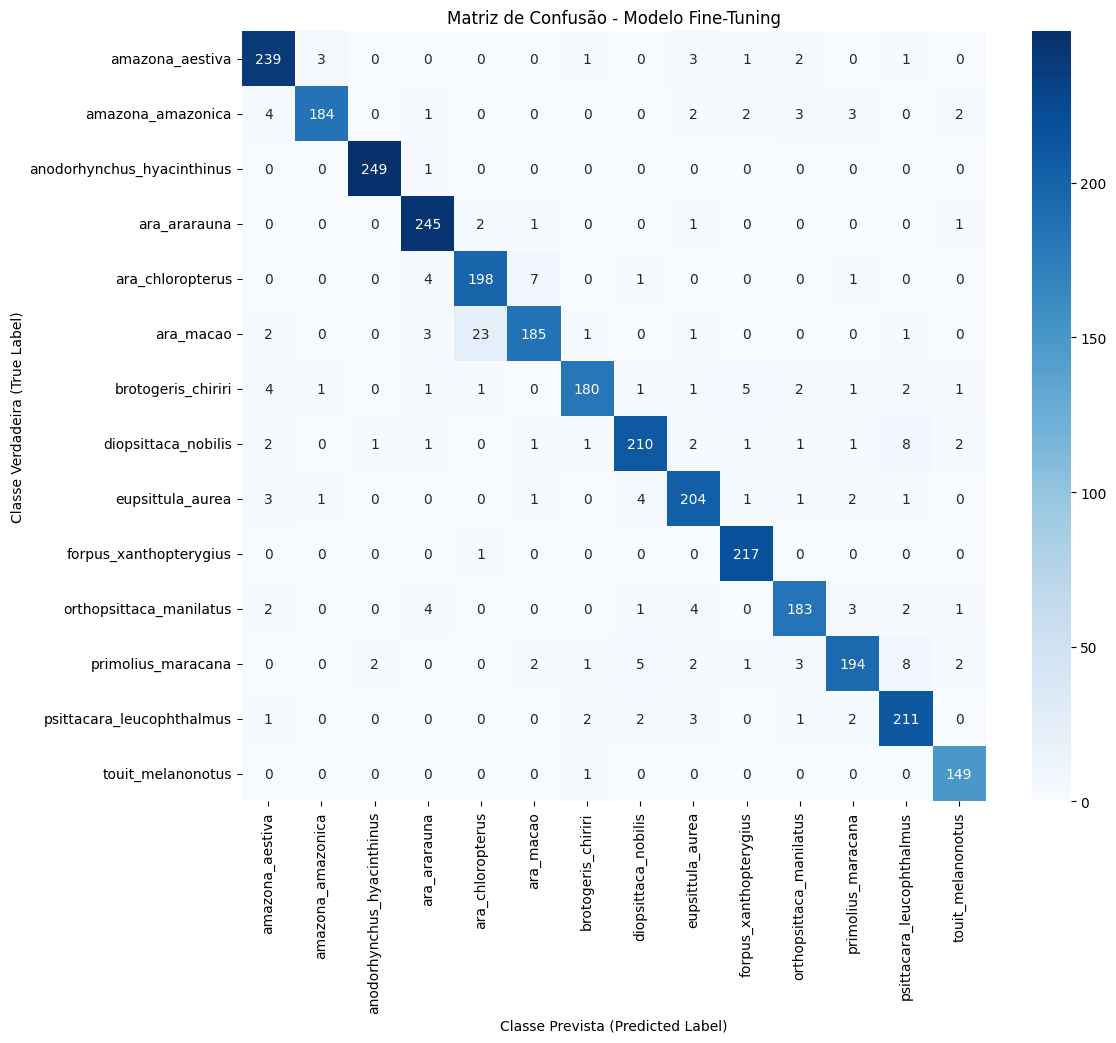

In [ ]:
# PARTE 1: IMPORTAÇÕES
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms, models # Import models
from torch.utils.data import DataLoader
import os

# PARTE 2: CARREGAMENTO DO MODELO SALVO (MODELO DE FINE-TUNING)

# --- Configurações Iniciais ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Caminho para o Modelo Salvo do TREINAMENTO COM FINE-TUNING ---
PATH_DO_MODELO_SALVO = '/content/drive/MyDrive/Dataset_Aves/Modelos_Salvos/best_finetuning_model.pth'

# --- Carregando o Modelo ResNet50 e a Cabeça Customizada ---
print("--- Carregando o modelo de Fine-Tuning (ResNet50) ---")
print(f"Dispositivo de execução: {DEVICE}")

# 1. Carregue a arquitetura ResNet50 pré-treinada no ImageNet
#    Para fine-tuning, você geralmente começa com pesos pré-treinados,
#    então carregamos a arquitetura com os pesos do ImageNet.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # Carrega a arquitetura ResNet50 com pesos

# 2. Substitua a camada final (classifier head) pela cabeça customizada usada no treino
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Linear(512, NUM_CLASSES)
)
print("Arquitetura ResNet50 carregada e cabeça customizada adicionada.")

# 3. Carregue os pesos (o 'state_dict') do arquivo salvo do SEU treino de FINE-TUNING
#    Este state_dict contém os pesos atualizados tanto da cabeça quanto das camadas descongeladas (layer4)
model.load_state_dict(torch.load(PATH_DO_MODELO_SALVO, map_location=DEVICE))
print(f"Pesos do modelo de Fine-Tuning carregados com sucesso de: {PATH_DO_MODELO_SALVO}")

# 4. Mova o modelo para o dispositivo (GPU ou CPU)
model.to(DEVICE)

# 5. **MUITO IMPORTANTE**: Coloque o modelo em modo de avaliação
#    Isso desativa camadas como Dropout e usa as médias/variâncias do BatchNorm aprendidas
model.eval()
print("Modelo em modo de avaliação (model.eval()) pronto para inferência.")
print("--------------------------\n")

# PARTE 3: PREPARAÇÃO DO DATASET DE VALIDAÇÃO

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Caminho para seu dataset de validação ---
Path_Validacao = '/content/drive/MyDrive/DatasetVALIDACAO'

# --- Definição das Transformações de Validação ---
validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Carregue o dataset de validação usando ImageFolder, aplicando as transformações definidas
validation_dataset = datasets.ImageFolder(root=Path_Validacao, transform=validation_transforms)

# Crie o DataLoader para carregar os dados em lotes (batches) de forma eficiente
# num_workers=2 usa processos paralelos para acelerar o carregamento dos dados
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Dataset de validação carregado de: {Path_Validacao}")
print(f"Número de imagens para validar: {len(validation_dataset)}")
print(f"Classes encontradas: {validation_dataset.classes}\n")


# PARTE 4: FUNÇÃO DE VALIDAÇÃO E GERAÇÃO DE MÉTRICAS

def get_predictions_and_labels(model_to_validate, loader, device):
    """
    Função aprimorada que itera sobre o dataset e retorna listas com
    todas as previsões e todos os rótulos verdadeiros.
    """
    # Coloca o modelo em modo de avaliação
    model_to_validate.eval()

    all_predictions = []
    all_true_labels = []

    # Desativa o cálculo de gradientes para acelerar a execução
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Gerando Previsões")
        for inputs, labels in progress_bar:
            # Mova os dados para o mesmo dispositivo do modelo
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Faça a predição
            outputs = model_to_validate(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Adicione as previsões e rótulos do batch às listas
            # .cpu().numpy() é necessário para usar com scikit-learn
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return all_true_labels, all_predictions

# --- 1. Obter as previsões do modelo no dataset de validação ---
print("Iniciando a validação do modelo de Fine-Tuning no dataset externo...")
true_labels, pred_labels = get_predictions_and_labels(model, validation_loader, DEVICE)
print("Validação concluída.\n")

# --- 2. Gerar o Relatório de Classificação (Precisão, Recall, F1-Score) ---
print("--- Relatório de Classificação (Fine-Tuning) ---")
# Obter os nomes das classes do dataset para um relatório mais legível
class_names = validation_dataset.classes
print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))


# --- 3. Gerar e Visualizar a Matriz de Confusão ---
print("\n--- Matriz de Confusão (Fine-Tuning) ---")
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Usar Seaborn e Matplotlib para criar uma visualização bonita
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão - Modelo Fine-Tuning')
plt.ylabel('Classe Verdadeira (True Label)')
plt.xlabel('Classe Prevista (Predicted Label)')
plt.show()

## **Benchmark de modelos**

Nesta parte, fizemos um benchmark dos modelos acima levando em consideração os testes de validação acima e utilizando scikit learn para impressão de dados gráficos.

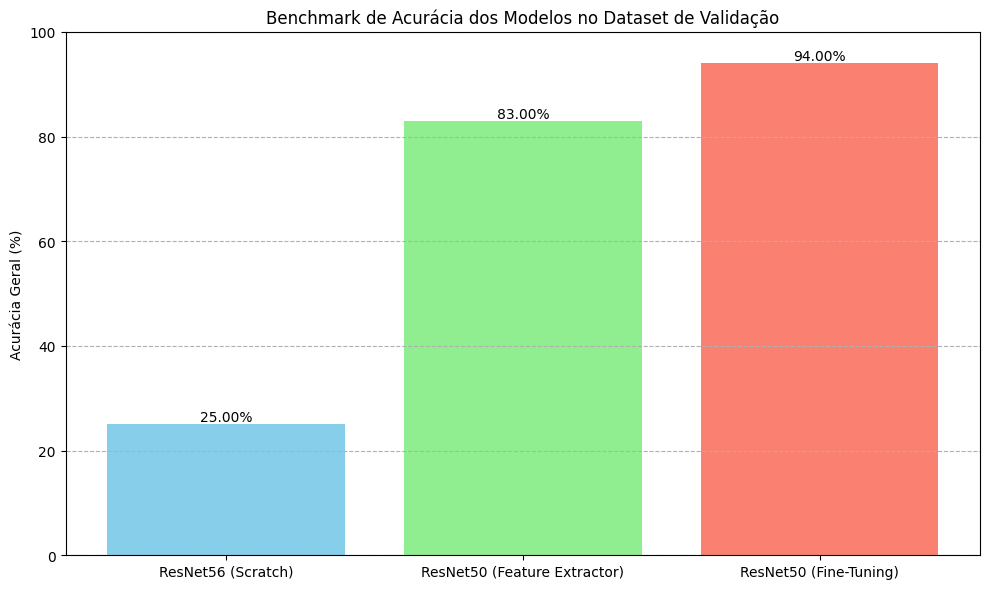

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

accuracy_resnet56_scratch = 25.00
accuracy_resnet50_fe = 83.00
accuracy_resnet50_ft = 94.00


models = ['ResNet56 (Scratch)', 'ResNet50 (Feature Extractor)', 'ResNet50 (Fine-Tuning)']
accuracies = [accuracy_resnet56_scratch, accuracy_resnet50_fe, accuracy_resnet50_ft]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center')

plt.ylim(0, 100)
plt.ylabel('Acurácia Geral (%)')
plt.title('Benchmark de Acurácia dos Modelos no Dataset de Validação')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### **Explicação das Diferenças de Performance dos Modelos**

O benchmark gráfico gerado demonstra claramente as diferenças significativas de acurácia entre os três modelos no dataset de validação. Essas diferenças podem ser explicadas pelos métodos de treinamento utilizados:

1.  **ResNet56 Treinada do Zero (Accuracy: ~25.00%)**
    *   **Método:** Este modelo foi construído e treinado completamente do zero. Isso significa que todos os pesos da rede neural foram inicializados aleatoriamente e tiveram que aprender a extrair características relevantes (como bordas, texturas, formas) e, subsequentemente, a classificar as diferentes espécies de aves, utilizando apenas os dados fornecidos no dataset.
    *   **Porquê a baixa acurácia?** Treinar uma rede profunda como a ResNet56 do zero geralmente requer um dataset muito grande e diversificado para que o modelo aprenda representações robustas e generalize bem. O dataset de 2879 imagens (mesmo com augmentation aplicada apenas no treino) é relativamente pequeno para treinar uma rede tão complexa a partir do zero para 14 classes. O modelo provavelmente sofreu com **overfitting** ou não convergiu bem devido à falta de dados suficientes. A acurácia próxima ao acaso (1/14 classes ≈ 7%) indica que o modelo não aprendeu a distinguir bem as classes.

2.  **ResNet50 como Extrator de Características (Transfer Learning) (Accuracy: ~83.00%)**
    *   **Método:** Este modelo utiliza uma ResNet50 pré-treinada no vasto dataset ImageNet (que contém milhões de imagens de diversas categorias). As camadas convolucionais da ResNet50 (que formam o "corpo" ou extrator de características) foram mantidas **congeladas**, ou seja, seus pesos não foram atualizados durante o treinamento no dataset de aves. Apenas a camada final (a "cabeça" de classificação), que foi substituída para ter 14 saídas (uma para cada espécie de ave), foi treinada no seu dataset.
    *   **Porquê a acurácia muito maior?** O modelo pré-treinado na ImageNet já aprendeu a detectar uma ampla gama de características visuais genéricas (pontos, linhas, texturas, padrões complexos) que são úteis para reconhecer objetos em geral, incluindo aves. Ao usar essas características pré-aprendidas e apenas treinar uma nova camada de classificação, aproveitando o conhecimento adquirido em um dataset maior. Isso é extremamente eficaz quando o próprio dataset é menor, pois o modelo não precisa aprender tudo do zero. Ele reutiliza o que já sabe sobre "ver".

3.  **ResNet50 com Fine-Tuning (Accuracy: ~94.00%)**
    *   **Método:** Este método também começou com a ResNet50 pré-treinada na ImageNet. No entanto, em vez de congelar completamente o corpo do modelo, apenas as primeiras camadas foram congeladas, e as camadas mais próximas da saída (`layer4` e a nova cabeça de classificação) foram **descongeladas** e treinadas (com uma taxa de aprendizado menor para as camadas pré-treinadas). Isso permite que o modelo ajuste (fine-tune) as características mais abstratas aprendidas na ImageNet para que se tornem ainda mais específicas e relevantes para a tarefa de classificação de aves do nosso dataset.
    *   **Porquê a melhor acurácia?** O Fine-tuning é uma extensão do extrator de características. Ele não apenas usa as características genéricas, mas também as adapta ligeiramente para melhor se adequarem aos detalhes específicos das imagens do dataset de aves. Como as características nas camadas mais profundas são mais específicas à tarefa original (ImageNet), ajustá-las para se alinharem melhor com as características das aves no nosso dataset resultou em um modelo mais poderoso e com maior capacidade de discriminação, levando à melhor acurácia observada.

**Em resumo:**

*   Treinar uma rede complexa do zero em um dataset pequeno é difícil e propenso a baixo desempenho, além de ser custosos computacionalmente.
*   Usar um modelo pré-treinado como extrator de características transfere conhecimento útil e melhora drasticamente o desempenho em datasets menores.
*   O Fine-tuning, ao ajustar as camadas mais profundas do modelo pré-treinado, permite uma adaptação mais fina ao novo dataset, resultando na melhor performance possível neste cenário.